***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Function Test</span> 

# Helmholtz Machine Predictive Processing


*Updated:* Feb 8, 2025


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [2]:
def para_init(n_dz):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [3]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [4]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [5]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [6]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * torch.where(q != 0, torch.log(q), -100) + (1-y) * torch.where(1-q != 0, torch.log(1-q), -100)).mean()
    return loss

In [7]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [8]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [9]:
def wake_phase(Phi,Theta,data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [10]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    return Phi, Loss

In [11]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = torch.zeros(n,dtype=int,device=dev)
    for i in range(n):
        binary = ''.join(bnr.to('cpu').numpy()[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [12]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [13]:
def one_step_prob_matrix(n_x, param,dev):
    """
    Arguments:
    n_x -- number of neurons at input layer x
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    dev -- torch device
    
    Returns:
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y).
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y)
    """
    X = binarilize(np.arange(2**n_x),n_x,dev)  # (n_x,2**n_x)
    q = one_step_forward(X,param)   # (n_y,2**n_x)
    prob_ft = torch.t(q)  # (2**n_x,n_y)
    
    # categorical probability
    n_y = q.shape[0]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_x, 2**n_y,device=dev)
    for i in range(2**n_x):
        prob_ct[i,:] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    
    # Ursatz = 1
    if n_x == 1:
        prob_ft = prob_ft[1:,:]
        prob_ct = prob_ct[1:,:]
    return prob_ft, prob_ct

In [14]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * torch.where(p != 0, torch.log(p), -100)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * torch.where(P != 0, torch.log(P), -100)).sum(axis=1,keepdims=True)
    return H

In [15]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber*torch.where(P_ber!=0,torch.log(P_ber),-100)+(1-P_ber)*torch.where((1-P_ber)!=0,torch.log(1-P_ber),-100))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [16]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*torch.where(p != 0, torch.log(p), -100) - p*torch.where(q != 0, torch.log(q), -100)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [17]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*torch.where(p != 0, torch.log(p), -100) - p*torch.where(q != 0, torch.log(q), -100) + \
                    (1-p)*torch.where(1-p != 0, torch.log(1-p), -100) - (1-p)*torch.where(1-q != 0, torch.log(1-q), -100)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [18]:
def prob_matrix_ct(dist_ct_pre, prob_ct):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ct -- categorical distribution at output layer y. Torch tensor of shape (n_prior,2**n_y), n_prior = 1 usually
    H_ct_Y -- categorical entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ct_YX -- conditional categorical entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ct = torch.matmul(dist_ct_pre,prob_ct)
    H_ct_Y = entropy(dist_ct)
    H_ct_YX = torch.matmul(dist_ct_pre,entropy(prob_ct))
    
    # I = H_Y - H_YX
    return dist_ct, H_ct_Y, H_ct_YX

In [19]:
def prob_matrix_ft(dist_ct_pre, prob_ft):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ft -- factorial distribution at output layer y. Torch tensor of shape (n_prior,n_y), n_prior = 1 usually
    H_ft_Y -- factorial entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ft_YX -- conditional factorial entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ft = torch.matmul(dist_ct_pre,prob_ft)
    H_ft_Y = entropy_bernoulli(dist_ft)
    H_ft_YX = torch.matmul(dist_ct_pre,entropy_bernoulli(prob_ft))
    
    # I = H_Y - H_YX
    return dist_ft, H_ft_Y, H_ft_YX

In [20]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

In [21]:
def preferred_generate(n_d):
    """
    preferred rules:
        1. Start with 1, end with 1
        2. Forbid 010
        3. Forbid 000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    preferred_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    preferred_set = np.zeros([1,n_d],dtype=int)
    preferred_set[0,:2] = 1
    preferred_set[0,-2:] = 1

    for i in range(2, n_d-2):
        for j in range(np.shape(preferred_set)[0]):
            prefix = preferred_set[j,i-2:i]
            if np.array_equal(prefix, [0,0]) or np.array_equal(prefix, [0,1]):
                preferred_set[j,i] = 1
            else:
                preferred_set = np.append(preferred_set, preferred_set[j:j+1,:], axis=0)
                preferred_set[j,i] = 1
    preferred_set = np.transpose(preferred_set)
    return preferred_set

In [40]:
preferred_set = preferred_generate(n_d)
preferred_set = torch.from_numpy(preferred_set).type(torch.int64).to(dev)
preferred_set.shape

torch.Size([12, 64])

In [41]:
preferred_dcm = decimalize(preferred_set,dev)
preferred_dcm

tensor([4095, 3583, 3839, 3327, 3967, 3711, 4031, 3519, 3903, 4063, 3551, 3807,
        3295, 3999, 3487, 4079, 3567, 3823, 3311, 3951, 3695, 4047, 3535, 3791,
        3279, 4087, 3575, 3831, 3319, 3959, 3703, 4023, 3511, 3895, 4071, 3559,
        3815, 3303, 3943, 3687, 4091, 3579, 3835, 3323, 3963, 3707, 4027, 3515,
        3899, 4059, 3547, 3803, 3291, 3995, 3483, 4083, 3571, 3827, 3315, 3955,
        3699, 4019, 3507, 3891], device='cuda:0')

In [42]:
well_formed_dcm = decimalize(well_formed_set,dev)
well_formed_dcm.shape

torch.Size([905])

In [43]:
torch.unique(torch.cat((well_formed_dcm,preferred_dcm))).shape

torch.Size([905])

In [44]:
def general_generate(n_d):
    """
    general rules:
        1. Start with 1 or 01
        2. Forbid 00100
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    general_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    general_set = np.zeros([1,n_d],dtype=int)

    for i in range(n_d):
        for j in range(np.shape(general_set)[0]):
            if i == 1 and general_set[j,0]==0:
                general_set[j,i] = 1
            elif i > 3 and np.array_equal(general_set[j,i-3:i], [0,0,0]):
                general_set[j,i] = 1
            elif i > 3 and np.array_equal(general_set[j,i-4:i], [0,0,1,0]):
                general_set[j,i] = 1
            else:
                general_set = np.append(general_set, general_set[j:j+1,:], axis=0)
                general_set[j,i] = 1
    general_set = np.transpose(general_set)
    return general_set

In [45]:
general_set = general_generate(n_d)
general_set = torch.from_numpy(general_set).type(torch.int64).to(dev)
general_set.shape

torch.Size([12, 1893])

In [46]:
general_dcm = decimalize(general_set,dev)

In [47]:
torch.unique(torch.cat((well_formed_dcm,general_dcm))).shape

torch.Size([1893])

In [48]:
def overlap_generate(n_d):
    """
    general rules:
        1. Start with 1 or 01
        2. Forbid 0100
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    general_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    overlap_set = np.zeros([1,n_d],dtype=int)

    for i in range(n_d):
        for j in range(np.shape(overlap_set)[0]):
            if i == 1 and overlap_set[j,0]==0:
                overlap_set[j,i] = 1
            elif i > 3 and np.array_equal(overlap_set[j,i-3:i], [0,1,0]):
                overlap_set[j,i] = 1
            elif i > 3 and np.array_equal(overlap_set[j,i-3:i], [0,0,0]):
                overlap_set[j,i] = 1
            else:
                overlap_set = np.append(overlap_set, overlap_set[j:j+1,:], axis=0)
                overlap_set[j,i] = 1
    overlap_set = np.transpose(overlap_set)
    return overlap_set

In [49]:
overlap_set = overlap_generate(n_d)
overlap_set = torch.from_numpy(overlap_set).type(torch.int64).to(dev)
overlap_set.shape

torch.Size([12, 1375])

In [50]:
overlap_dcm = decimalize(overlap_set,dev)

In [51]:
torch.unique(torch.cat((well_formed_dcm,overlap_dcm))).shape

torch.Size([1633])

In [52]:
value,count = torch.unique(torch.cat((well_formed_dcm,overlap_dcm)),return_counts=True)
pt2 = value[torch.where(count==2)]

In [53]:
value,count = torch.unique(torch.cat((well_formed_dcm,pt2)),return_counts=True)
pt1 = value[torch.where(count==1)]

In [54]:
value,count = torch.unique(torch.cat((overlap_dcm,pt2)),return_counts=True)
pt3 = value[torch.where(count==1)]

In [55]:
value,count = torch.unique(torch.cat((torch.cat((pt1,pt2,pt3)),torch.arange(2**n_d,device=dev))),return_counts=True)
pt4 = value[torch.where(count==1)]

In [56]:
order = torch.cat((pt1,pt2,pt3,pt4))
order.shape

torch.Size([4096])

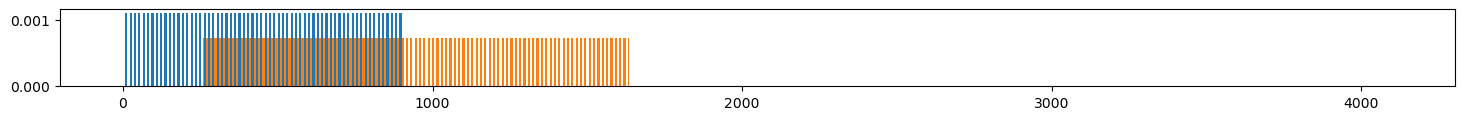

In [57]:
fig, ax = plt.subplots(figsize=(18, 1))
ax.bar(np.arange(2**n_dz[0]),ground_truth(well_formed_set,dev)[order].to('cpu').numpy(),width=0.5,align='edge')
ax.bar(np.arange(2**n_dz[0])+0.5,ground_truth(overlap_set,dev)[order].to('cpu').numpy(),width=0.5,align='edge')
plt.show()

## Model

In [28]:
dev = torch.device("cuda") # operate on GPU "cuda" or CPU "cpu"

In [29]:
structure = [12,10,8,6,3,1]
n_dz = torch.tensor(structure)
n_dz

tensor([12, 10,  8,  6,  3,  1])

In [30]:
n_layer = len(n_dz)
n_layer

6

In [31]:
n_d = n_dz[0]
n_d

tensor(12)

In [32]:
well_formed = well_formed_generate(n_d)
well_formed.shape

(12, 905)

In [33]:
well_formed_set = torch.from_numpy(well_formed).type(torch.int64).to(dev)
well_formed_set

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 0, 1,  ..., 1, 1, 0],
        [1, 1, 0,  ..., 0, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')

In [34]:
Phi,Theta = para_init(n_dz)
Phi

{'Phi_01': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0'),
 'Phi_12': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 

In [35]:
data = well_formed_set
n_data = well_formed_set.shape[1]
n_data

905

In [36]:
data_dcm = decimalize(well_formed_set,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011], device='cuda:0')

In [37]:
data_dist_ft = well_formed_set.sum(axis=1)/n_data
data_dist_ft

tensor([1.0000, 0.6530, 0.6939, 0.5536, 0.5713, 0.5934, 0.6077, 0.6000, 0.6033,
        0.6331, 0.6254, 0.4785], device='cuda:0')

In [38]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
col_list.append('Recog_D_KL_Layer_0')
for i in range(n_layer-1):
    if i > 0:
        col_list.append('Recog_H_Layer_'+str(i))
        col_list.append('Recog_I_Layer_'+str(i))
        col_list.append('Recog_D_KL_Layer_'+str(i))
    col_list.append('Gen_H_Layer_'+str(i))
    col_list.append('Gen_I_Layer_'+str(i))
    col_list.append('Gen_D_KL_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Recog_D_KL_Layer_0',
 'Gen_H_Layer_0',
 'Gen_I_Layer_0',
 'Gen_D_KL_Layer_0',
 'Recog_H_Layer_1',
 'Recog_I_Layer_1',
 'Recog_D_KL_Layer_1',
 'Gen_H_Layer_1',
 'Gen_I_Layer_1',
 'Gen_D_KL_Layer_1',
 'Recog_H_Layer_2',
 'Recog_I_Layer_2',
 'Recog_D_KL_Layer_2',
 'Gen_H_Layer_2',
 'Gen_I_Layer_2',
 'Gen_D_KL_Layer_2',
 'Recog_H_Layer_3',
 'Recog_I_Layer_3',
 'Recog_D_KL_Layer_3',
 'Gen_H_Layer_3',
 'Gen_I_Layer_3',
 'Gen_D_KL_Layer_3',
 'Recog_H_Layer_4',
 'Recog_I_Layer_4',
 'Recog_D_KL_Layer_4',
 'Gen_H_Layer_4',
 'Gen_I_Layer_4',
 'Gen_D_KL_Layer_4']

In [39]:
len(col_list)

37

### Train with Batch

In [61]:
# Analytic_ws_batch = pd.DataFrame(columns=col_list)
# Analytic_ws_batch

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Recog_D_KL_Layer_0,...,Recog_D_KL_Layer_3,Gen_H_Layer_3,Gen_I_Layer_3,Gen_D_KL_Layer_3,Recog_H_Layer_4,Recog_I_Layer_4,Recog_D_KL_Layer_4,Gen_H_Layer_4,Gen_I_Layer_4,Gen_D_KL_Layer_4


In [62]:
# Phi,Theta = para_init(n_dz)

In [33]:
Analytic_ws_batch = pd.read_csv('Analytic_ws_batch.csv', sep=",")
Analytic_ws_batch

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Recog_D_KL_Layer_0,...,Recog_D_KL_Layer_3,Gen_H_Layer_3,Gen_I_Layer_3,Gen_D_KL_Layer_3,Recog_H_Layer_4,Recog_I_Layer_4,Recog_D_KL_Layer_4,Gen_H_Layer_4,Gen_I_Layer_4,Gen_D_KL_Layer_4
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,68.994232,...,0.000012,4.158881,9.536743e-07,0.000012,2.079438,9.536743e-07,0.000007,2.079439,0.0,0.000006
1,0.691468,0.693039,0.693183,0.693046,0.616928,0.692587,0.693104,0.693093,0.693318,33.012474,...,0.000131,4.158812,6.628036e-05,0.000130,2.079191,8.130074e-05,0.000086,2.079327,0.0,0.000085
2,0.689466,0.693011,0.693128,0.692630,0.614550,0.689150,0.693249,0.692969,0.693229,31.326004,...,0.000017,4.158498,1.745224e-04,0.000016,2.079260,9.799004e-05,0.000026,2.079244,0.0,0.000026
3,0.688073,0.693303,0.692915,0.693097,0.614205,0.686890,0.691830,0.692660,0.692917,30.740173,...,0.000145,4.158237,3.027916e-04,0.000145,2.079297,1.435280e-04,0.000003,2.079253,0.0,0.000003
4,0.684058,0.691606,0.692689,0.693507,0.614066,0.687006,0.691499,0.692571,0.692510,30.498985,...,0.000229,4.157988,3.771782e-04,0.000229,2.079173,1.442432e-04,0.000056,2.079008,0.0,0.000055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,0.265112,0.514316,0.487237,0.391851,0.345046,0.479688,0.557601,0.532164,0.466547,6.710065,...,0.000447,3.369449,1.912861e-01,0.000443,1.413319,1.907634e-01,0.000012,1.414092,0.0,0.000011
2197,0.260851,0.528620,0.500634,0.416142,0.350034,0.481594,0.563655,0.519253,0.465670,6.712999,...,0.000339,3.356569,1.914661e-01,0.000334,1.413210,1.898803e-01,0.000015,1.411132,0.0,0.000014
2198,0.273934,0.516208,0.486625,0.407732,0.346137,0.476487,0.565469,0.516958,0.478469,6.719982,...,0.000366,3.352261,1.908796e-01,0.000359,1.408082,1.892189e-01,0.000017,1.410681,0.0,0.000017
2199,0.273755,0.529722,0.496625,0.409228,0.346964,0.485345,0.562294,0.529739,0.471317,6.709084,...,0.000311,3.359583,1.914580e-01,0.000305,1.413376,1.904778e-01,0.000018,1.415845,0.0,0.000017


In [131]:
para = np.load('Parameters_ws_batch.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

In [254]:
batch_size = n_data
data = well_formed_set
lr = 0.1
epoch = 1000

In [1]:
# for e in range(epoch):
#     Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev)
#     Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
#     print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
#     if e % 100 == 0:
#         stat = []
#         stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
#         stat = stat + list((Loss_sleep).to('cpu').numpy())
#         wake_ct = {}
#         sleep_ct = {}
#         wake_ct['Layer 0: dist'] = data_dist
#         dist_ct_pre_s = torch.ones(1,device=dev)
#         dist_ct_pre_w = data_dist
#         for i in range(n_layer-1):
#             prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
#             sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
#             sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
#             dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']

#             if i < n_layer-2:
#                 prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
#                 wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
#                 wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)
#                 dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']
#         for i in range(n_layer-1):
#             dist_w = wake_ct['Layer '+str(i)+': dist']
#             dist_s = sleep_ct['Layer '+str(i)+': dist']
#             if i == 0:
#                 D_KL_w = KL_divergence(dist_s,dist_w).item()
#                 stat.append(D_KL_w)
#             if i > 0:
#                 H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
#                 stat.append(H_Y_w)
#                 H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
#                 I_w = H_Y_w - H_YX_w
#                 stat.append(I_w)
#                 D_KL_w = KL_divergence(dist_s,dist_w).item()
#                 stat.append(D_KL_w)
#             H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
#             stat.append(H_Y_s)
#             H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
#             I_s = H_Y_s - H_YX_s
#             stat.append(I_s)
#             D_KL_s = KL_divergence(dist_w,dist_s).item()
#             stat.append(D_KL_s)
#         Analytic_ws_batch.loc[len(Analytic_ws_batch)] = stat

In [256]:
Analytic_ws_batch

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Recog_D_KL_Layer_0,...,Recog_D_KL_Layer_3,Gen_H_Layer_3,Gen_I_Layer_3,Gen_D_KL_Layer_3,Recog_H_Layer_4,Recog_I_Layer_4,Recog_D_KL_Layer_4,Gen_H_Layer_4,Gen_I_Layer_4,Gen_D_KL_Layer_4
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,68.994232,...,0.000012,4.158881,9.536743e-07,0.000012,2.079438,9.536743e-07,0.000007,2.079439,0.0,0.000006
1,0.691468,0.693039,0.693183,0.693046,0.616928,0.692587,0.693104,0.693093,0.693318,33.012474,...,0.000131,4.158812,6.628036e-05,0.000130,2.079191,8.130074e-05,0.000086,2.079327,0.0,0.000085
2,0.689466,0.693011,0.693128,0.692630,0.614550,0.689150,0.693249,0.692969,0.693229,31.326004,...,0.000017,4.158498,1.745224e-04,0.000016,2.079260,9.799004e-05,0.000026,2.079244,0.0,0.000026
3,0.688073,0.693303,0.692915,0.693097,0.614205,0.686890,0.691830,0.692660,0.692917,30.740173,...,0.000145,4.158237,3.027916e-04,0.000145,2.079297,1.435280e-04,0.000003,2.079253,0.0,0.000003
4,0.684058,0.691606,0.692689,0.693507,0.614066,0.687006,0.691499,0.692571,0.692510,30.498985,...,0.000229,4.157988,3.771782e-04,0.000229,2.079173,1.442432e-04,0.000056,2.079008,0.0,0.000055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,0.265112,0.514316,0.487237,0.391851,0.345046,0.479688,0.557601,0.532164,0.466547,6.710065,...,0.000447,3.369449,1.912861e-01,0.000443,1.413319,1.907634e-01,0.000012,1.414092,0.0,0.000011
2197,0.260851,0.528620,0.500634,0.416142,0.350034,0.481594,0.563655,0.519253,0.465670,6.712999,...,0.000339,3.356569,1.914661e-01,0.000334,1.413210,1.898803e-01,0.000015,1.411132,0.0,0.000014
2198,0.273934,0.516208,0.486625,0.407732,0.346137,0.476487,0.565469,0.516958,0.478469,6.719982,...,0.000366,3.352261,1.908796e-01,0.000359,1.408082,1.892189e-01,0.000017,1.410681,0.0,0.000017
2199,0.273755,0.529722,0.496625,0.409228,0.346964,0.485345,0.562294,0.529739,0.471317,6.709084,...,0.000311,3.359583,1.914580e-01,0.000305,1.413376,1.904778e-01,0.000018,1.415845,0.0,0.000017


In [83]:
# Analytic_ws_online.dtypes

In [257]:
parameters = {'Phi': Phi, 'Theta': Theta}

In [258]:
# np.save('Parameters_ws_batch',parameters)

In [259]:
# Analytic_ws_batch.to_csv('Analytic_ws_batch.csv', index = False)

In [135]:
wake_ft = {}
sleep_ft = {}
wake_ct = {}
sleep_ct = {}
wake_ct['Layer 0: dist'] = data_dist
wake_ct['Layer 0: H_Y'] = entropy(data_dist)
wake_ft['Layer 0: dist'] = data_dist_ft
wake_ft['Layer 0: H_Y'] = entropy_bernoulli(data_dist_ft)
dist_ct_pre_s = torch.ones(1,device=dev)
dist_ct_pre_w = data_dist
for i in range(n_layer-1):
    prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
    
    sleep_ft['Layer '+str(n_layer-2-i)+': dist'], sleep_ft['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ft['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ft(dist_ct_pre_s, prob_ft_s)
    dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']
    
    if i < n_layer-2:
        prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
        wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)

        wake_ft['Layer '+str(i+1)+': dist'], wake_ft['Layer '+str(i+1)+': H_Y'], \
        wake_ft['Layer '+str(i+1)+': H_YX'] = prob_matrix_ft(dist_ct_pre_w, prob_ft_w)
        dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']

Layer 0 Data_dist D_KL: 6.7114 H(Y): 6.8079
Layer 0 Gen_dist D_KL: 0.1176 H(Y): 6.9581
Layer 1 Recognition Distribution D_KL: 0.0077 H(Y): 5.4575 H(Y|X): 2.7084 I_XY: 2.7491
Layer 1 Generative  Distribution D_KL: 0.0072 H(Y): 6.9581 H(Y|X): 4.194 I_XY: 2.7641
Layer 2 Recognition Distribution D_KL: 0.0009 H(Y): 4.8741 H(Y|X): 4.1935 I_XY: 0.6806
Layer 2 Generative  Distribution D_KL: 0.0009 H(Y): 5.47 H(Y|X): 4.7875 I_XY: 0.6825
Layer 3 Recognition Distribution D_KL: 0.0003 H(Y): 3.3529 H(Y|X): 2.9683 I_XY: 0.3846
Layer 3 Generative  Distribution D_KL: 0.0003 H(Y): 4.8814 H(Y|X): 4.4973 I_XY: 0.3841
Layer 4 Recognition Distribution D_KL: 0.0 H(Y): 1.4148 H(Y|X): 1.225 I_XY: 0.1898
Layer 4 Generative  Distribution D_KL: 0.0 H(Y): 3.3538 H(Y|X): 3.1632 I_XY: 0.1906


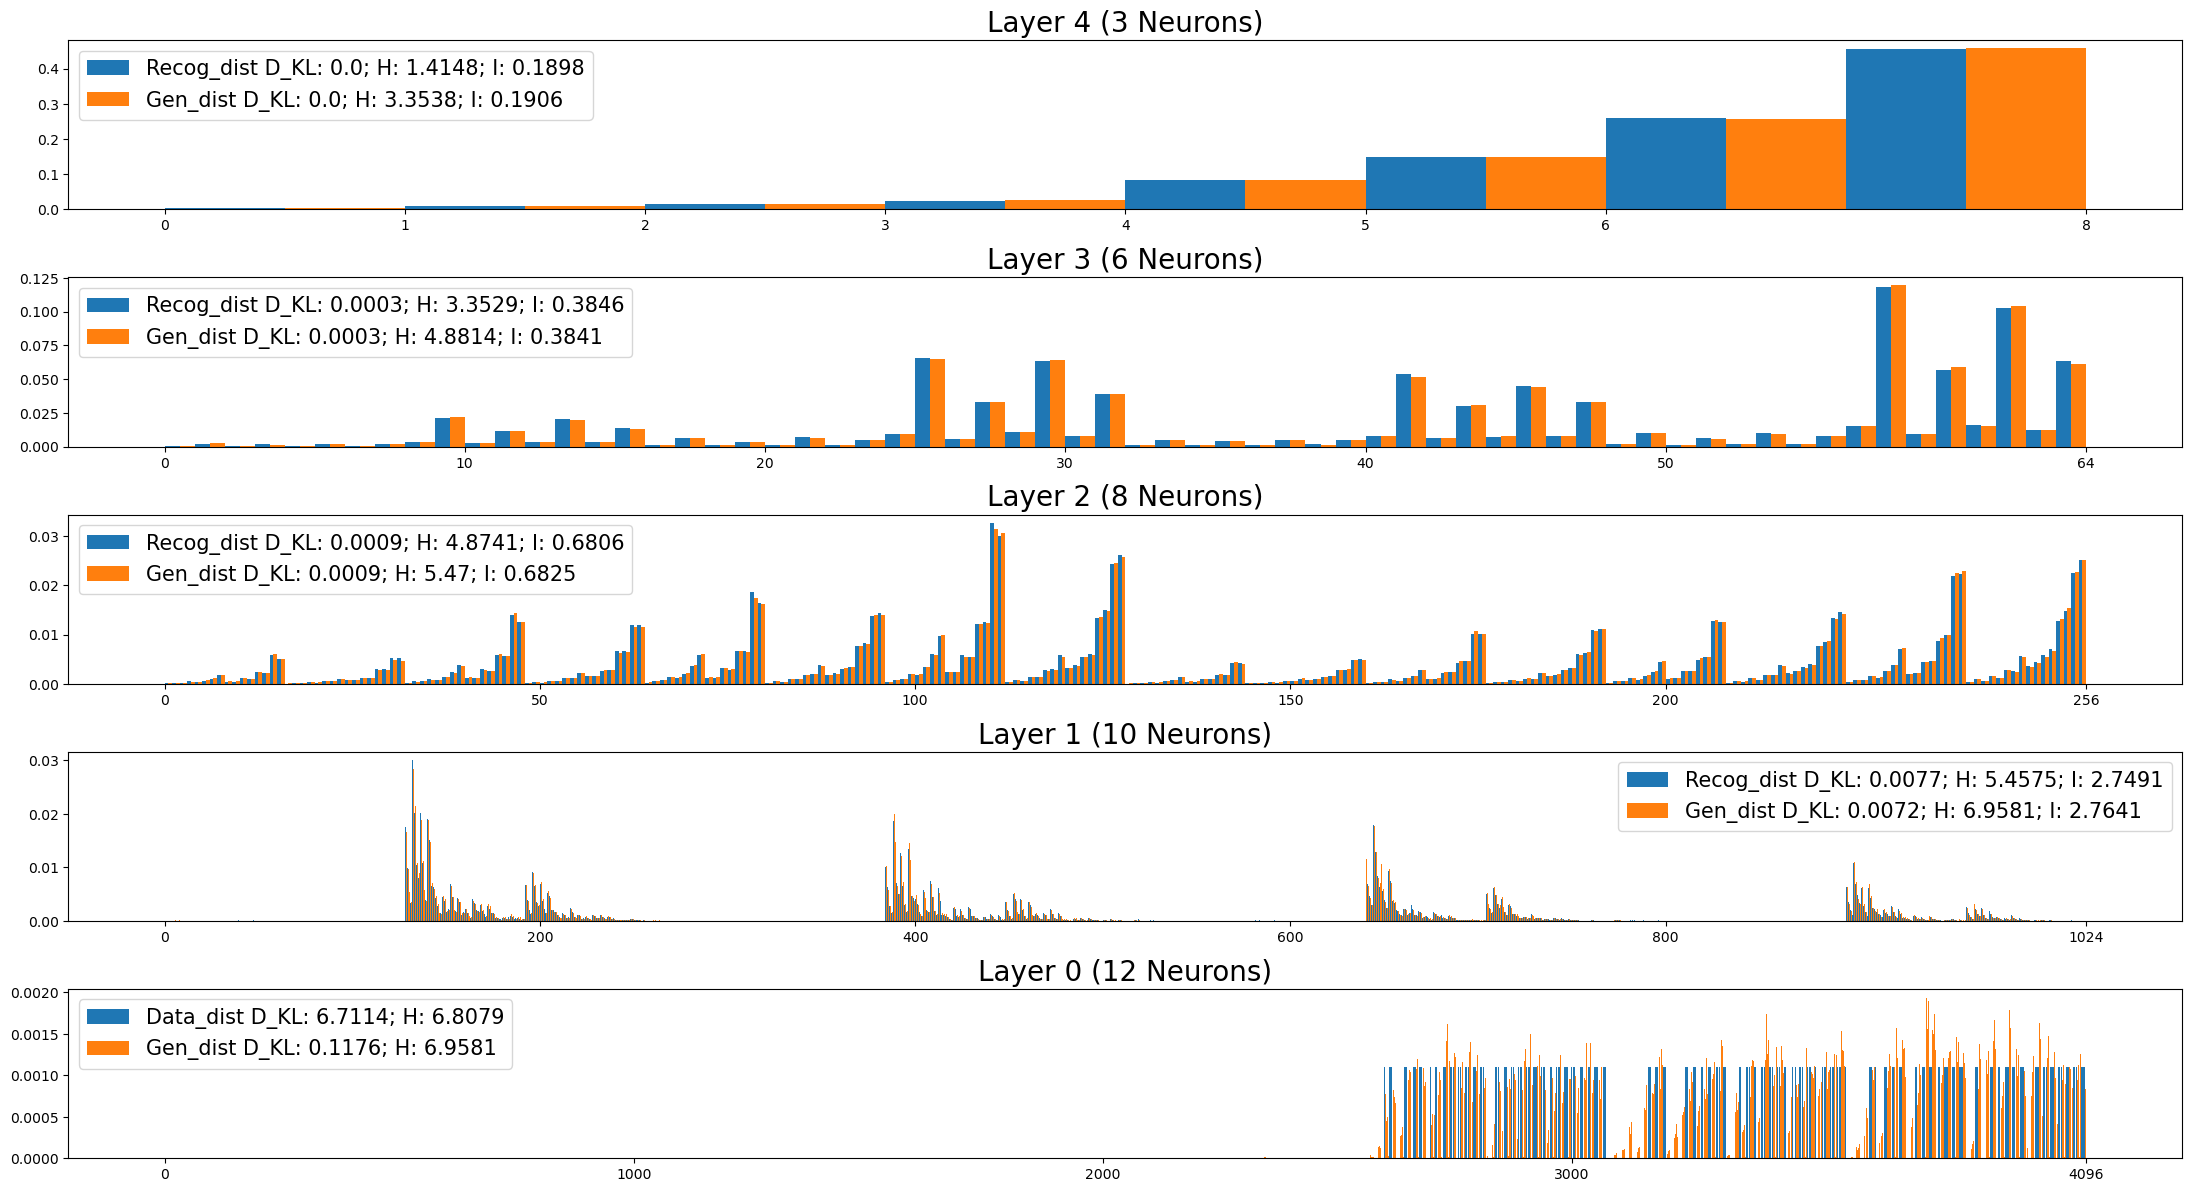

In [136]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 12))
# fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)

for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    dist_s = sleep_ct['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
    
        H_Y_s = sleep_ct['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ct['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
    x_lim = 2**(n_dz[n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)
    

plt.tight_layout(pad=1)    
plt.show()

Layer 0 Data_dist D_KL: 0.0008 H(Y): 7.3327
Layer 0 Gen_dist D_KL: 0.0001 H(Y): 7.333
Layer 1 Recognition Distribution D_KL: 0.0 H(Y): 5.5111 H(Y|X): 2.7084 I_XY: 2.8027
Layer 1 Generative  Distribution D_KL: 0.0 H(Y): 7.333 H(Y|X): 4.194 I_XY: 3.139
Layer 2 Recognition Distribution D_KL: 0.0001 H(Y): 4.8955 H(Y|X): 4.1935 I_XY: 0.702
Layer 2 Generative  Distribution D_KL: 0.0001 H(Y): 5.511 H(Y|X): 4.7875 I_XY: 0.7234
Layer 3 Recognition Distribution D_KL: 0.0 H(Y): 3.3625 H(Y|X): 2.9683 I_XY: 0.3942
Layer 3 Generative  Distribution D_KL: 0.0 H(Y): 4.9012 H(Y|X): 4.4973 I_XY: 0.4039
Layer 4 Recognition Distribution D_KL: 0.0 H(Y): 1.4149 H(Y|X): 1.225 I_XY: 0.1898
Layer 4 Generative  Distribution D_KL: 0.0 H(Y): 3.3637 H(Y|X): 3.1632 I_XY: 0.2004


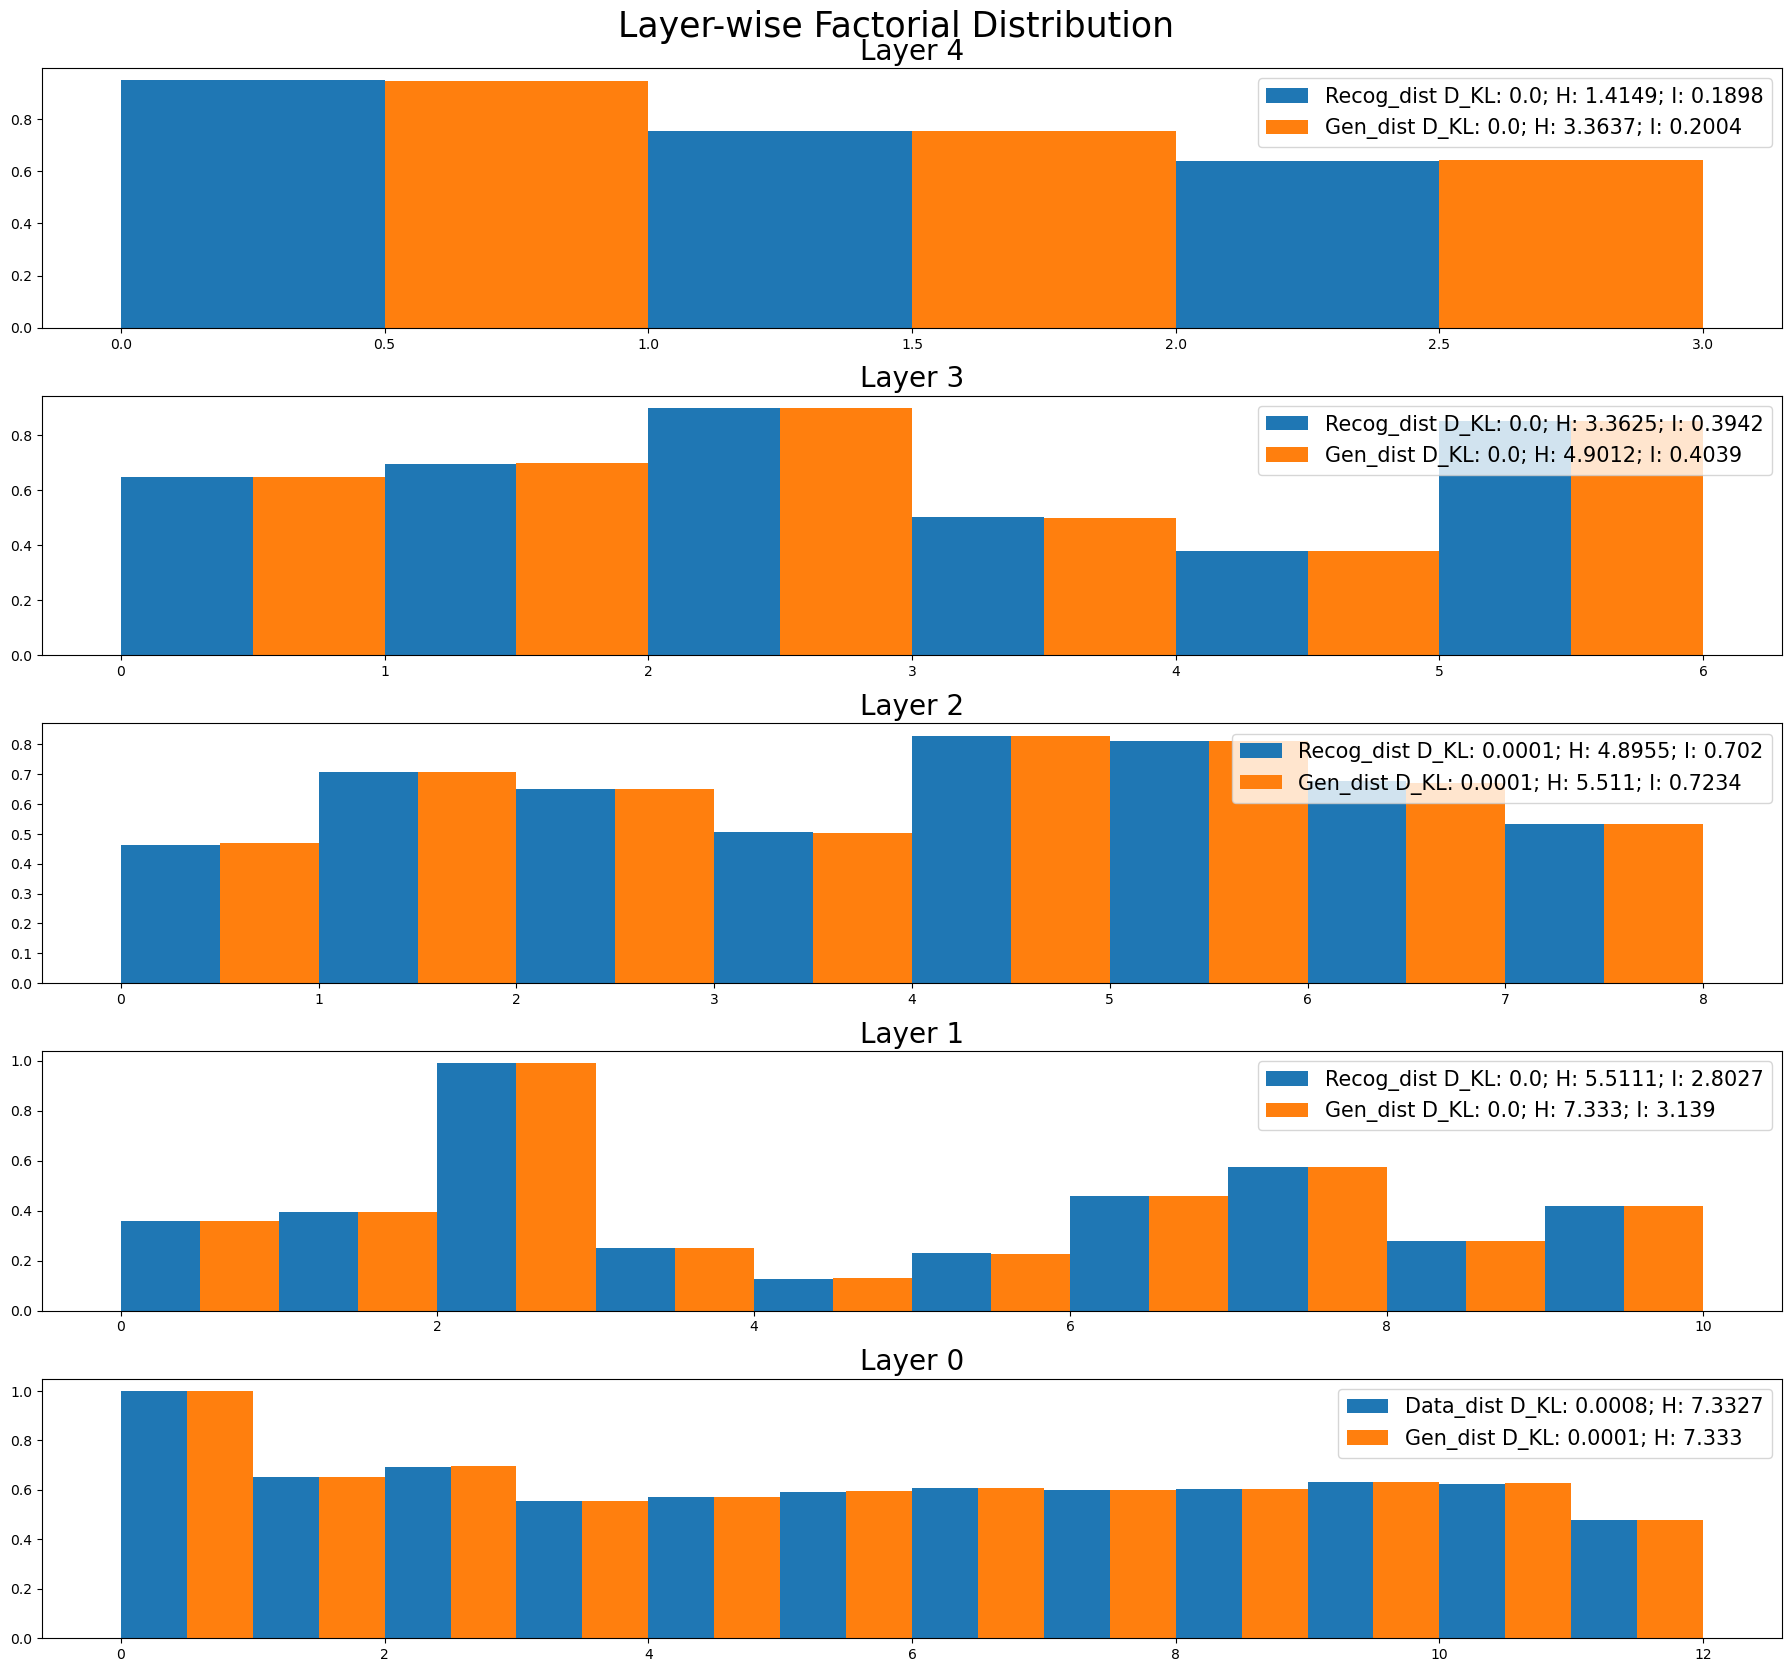

In [134]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(18, 17))
fig_ct.suptitle("Layer-wise Factorial Distribution",fontsize=25)
for i in range(n_layer-1):
    dist_s = sleep_ft['Layer '+str(i)+': dist']
    dist_w = wake_ft['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ft['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ft['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
           
        H_Y_s = sleep_ft['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ft['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
        H_Y_w = wake_ft['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
        H_Y_s = sleep_ft['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i),fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)

plt.tight_layout(pad=1)    
plt.show()

In [138]:
def causal(n_dz, Theta, cause_layer, cause_indices, dev):
    """
    Arguments:
    n_dz -- structure of the Hemholtz machine, torch tensor of shape (n_layer, )
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    cause_layer -- layer number of the cause. Integer
    cause_indices -- the indices of the causes out of 2^n_x in its layer. Torch tensor of shape (n_cause, )
    dev -- torch device
    
    Returns:
    causal_dist -- dictionary of causal ditributions, of length cause_layer.
    """
    causal_dist = {}
    prob_ft, prob_ct = one_step_prob_matrix(n_dz[cause_layer], Theta["Theta_" + str(cause_layer) + str(cause_layer-1)], dev) # (2**n_z, 2**n_{z-1})
    dist_ct_pre = prob_ct[cause_indices,:]
    causal_dist['Layer '+str(cause_layer-1)+': dist'] = dist_ct_pre
    for i in range(1,cause_layer):
        prob_ft, prob_ct = one_step_prob_matrix(n_dz[cause_layer-i], Theta["Theta_" + str(cause_layer-i) + str(cause_layer-i-1)],dev)
        causal_dist['Layer '+str(cause_layer-i-1)+': dist'], causal_dist['Layer '+str(cause_layer-i-1)+': H_Y'], \
        causal_dist['Layer '+str(cause_layer-i-1)+': H_YX'] = prob_matrix_ct(dist_ct_pre, prob_ct)
        dist_ct_pre = causal_dist['Layer '+str(cause_layer-i-1)+': dist']
    return causal_dist

In [139]:
cause_layer = 4
cause_indices = torch.arange(2**n_dz[cause_layer])
causal_dist = causal(n_dz, Theta, cause_layer, cause_indices, dev)
causal_dist

{'Layer 3: dist': tensor([[1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02],
         [8.6053e-03, 1.6621e-02, 4.9294e-03, 9.5208e-03, 4.1435e-03, 8.0030e-03,
          2.3735e-03, 

In [140]:
bnr = binarilize(cause_indices,n_dz[cause_layer],dev).to('cpu').numpy()
bnr

array([[0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 1, 0, 1]], dtype=int64)

In [ ]:
fig, ax = plt.subplots(cause_layer*int(len(cause_indices)/2+0.5), 2, figsize=(18, 30))
fig.suptitle("Causal Distributions",fontsize=25)
for j in range(len(cause_indices)):
    row_ind = int(j/2)*cause_layer
    col_ind = j%2
    for i in range(cause_layer-1,-1,-1):
        dist = causal_dist['Layer '+str(i)+': dist'][j,:]
        ax[row_ind+cause_layer-1-i, col_ind].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.5,align='edge',\
                               label = "Data Distribution")
        ax[row_ind+cause_layer-1-i, col_ind].set_title("Layer "+str(i)+'('+''.join(bnr[:,j].reshape(n_dz[cause_layer],).astype(str))+')',fontsize=20)
    
#     H_Y = causal_dist['Layer '+str(i)+': H_Y'].item()
#     H_YX = causal_dist['Layer '+str(i)+': H_YX'].item()
#     I = H_Y - H_YX
#     ax[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
#                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
#                                str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
#     ax[n_layer-2-i].legend(fontsize=15)
    
plt.tight_layout(pad=1)    
plt.show()

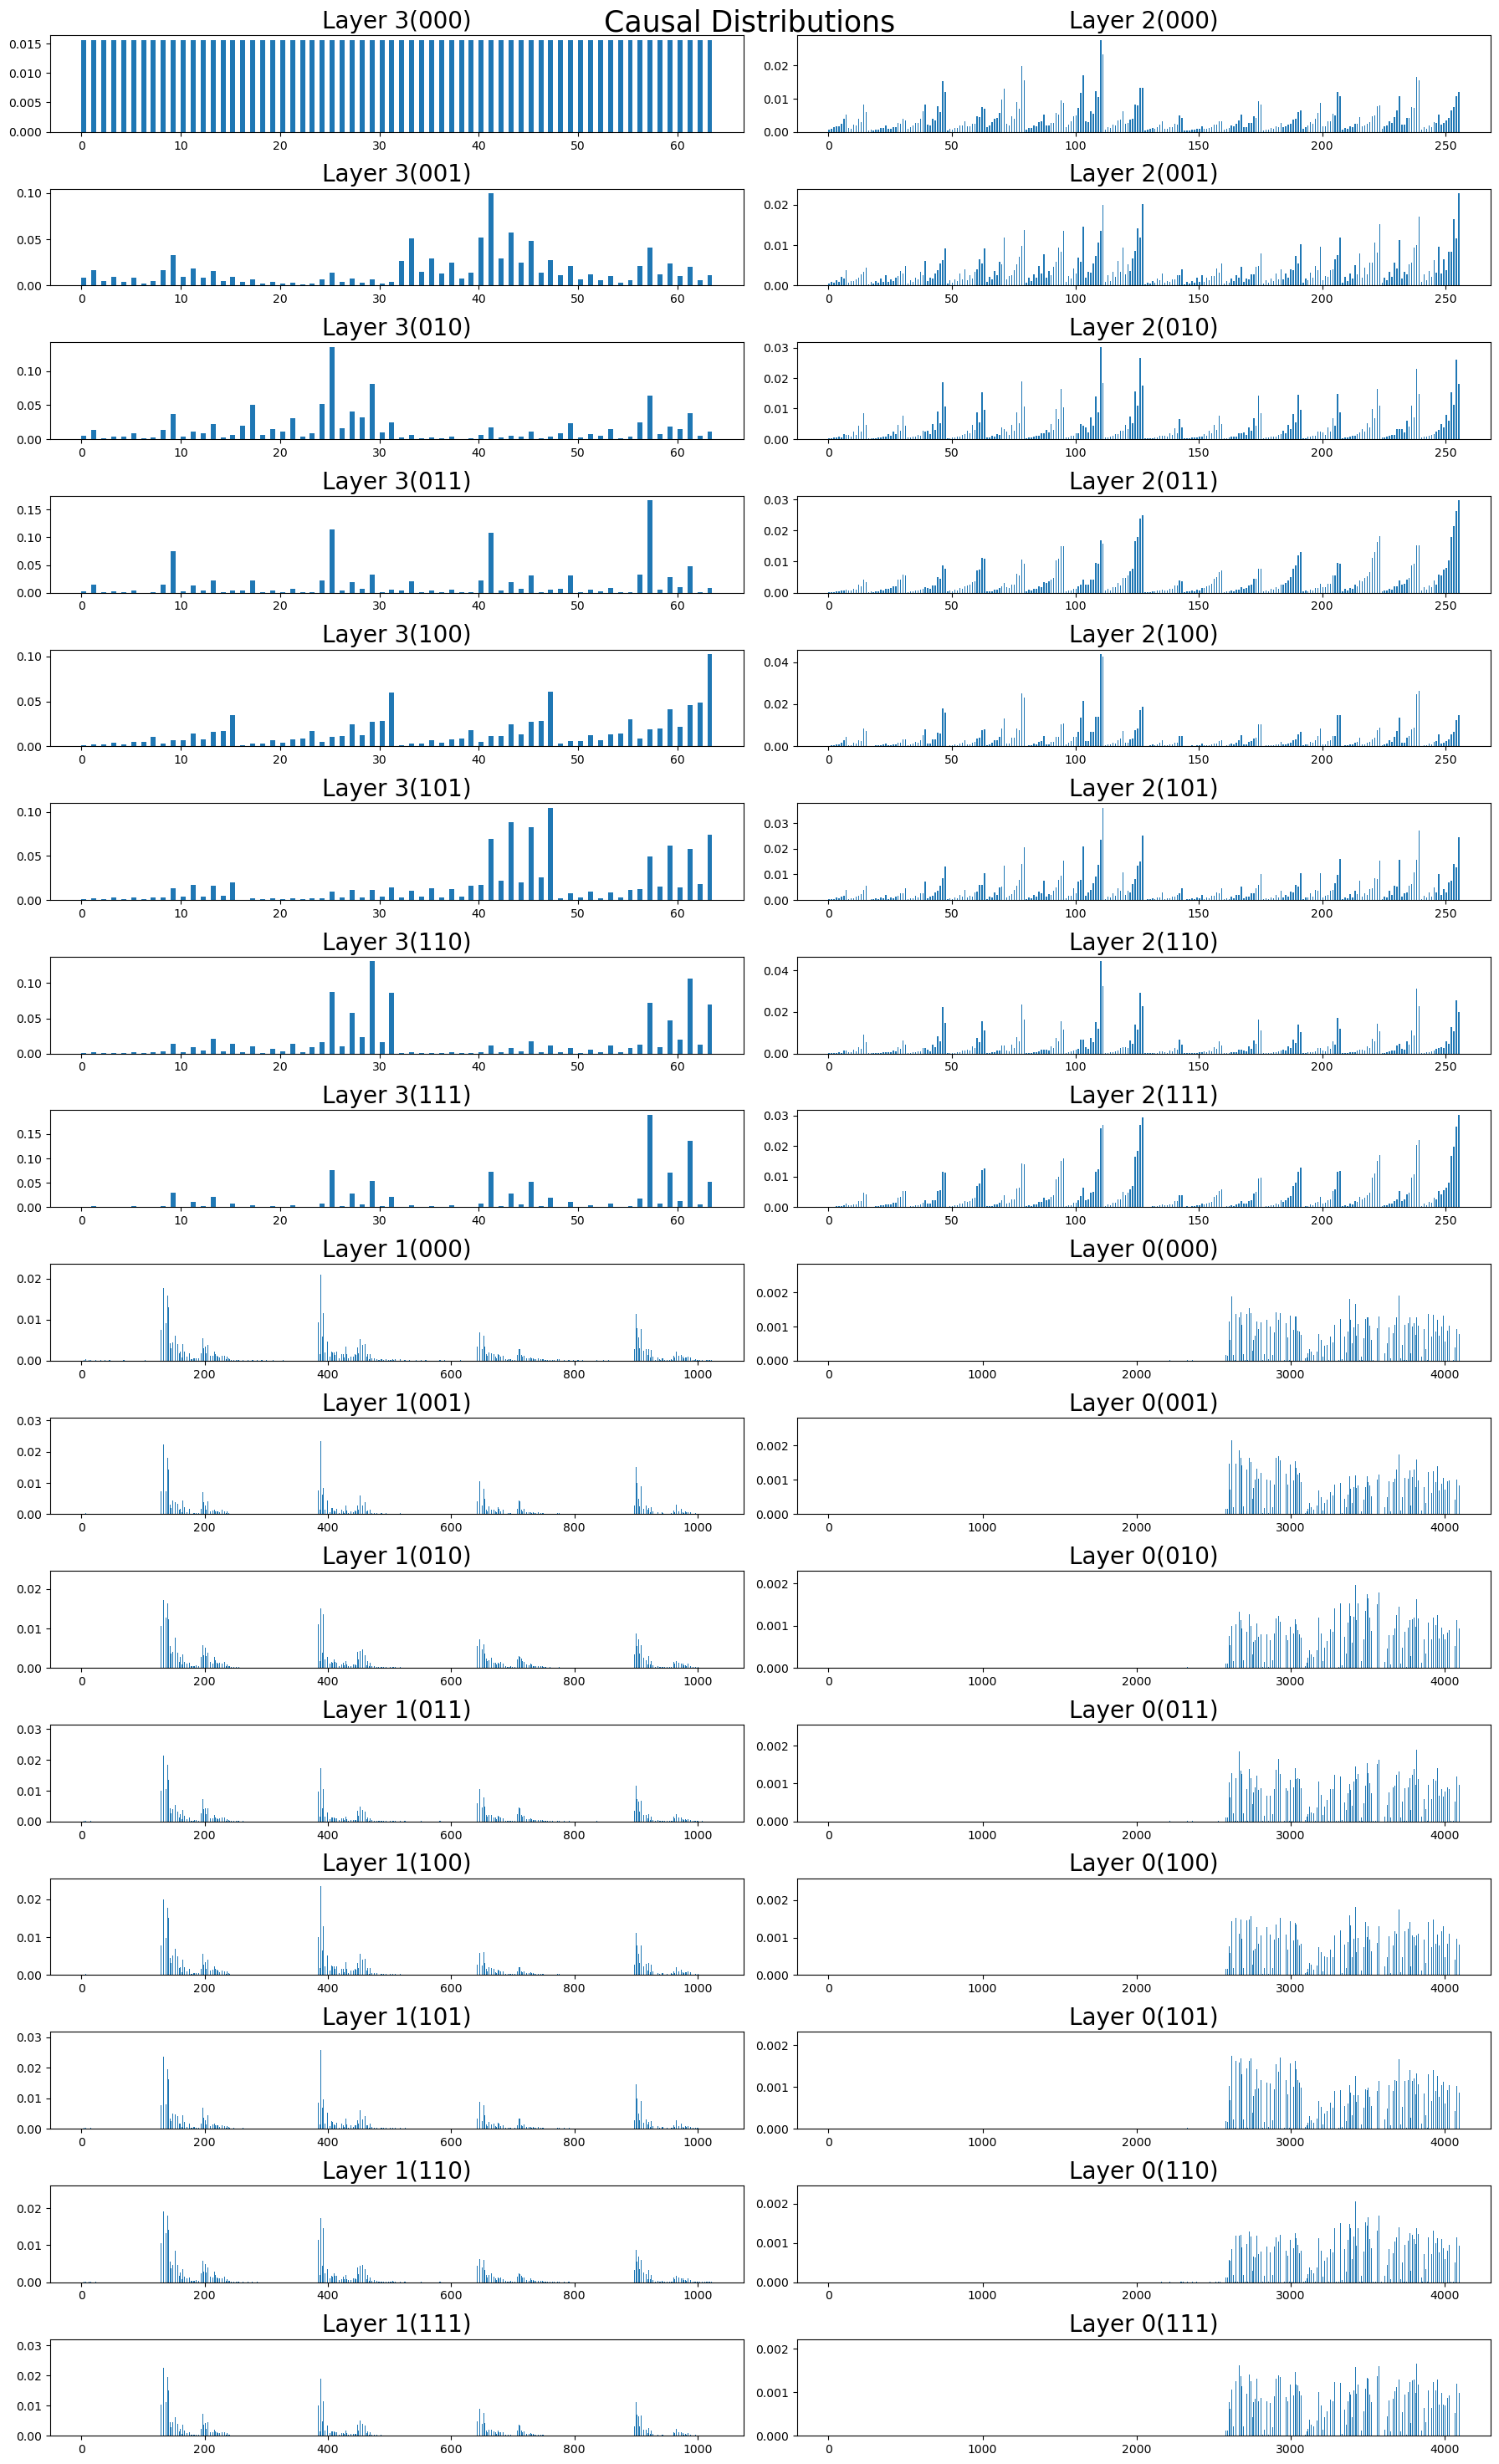

In [141]:
fig, ax = plt.subplots(cause_layer*int(len(cause_indices)/2+0.5), 2, figsize=(18, 30))
fig.suptitle("Causal Distributions",fontsize=25)
for i in range(cause_layer-1,-1,-1):
    row_ind = int((cause_layer-1-i)/2)*len(cause_indices)
    col_ind = (cause_layer-1-i)%2
    for j in range(len(cause_indices)):
        dist = causal_dist['Layer '+str(i)+': dist'][j,:]
        ax[row_ind+j, col_ind].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.5,align='edge',\
                               label = "Data Distribution")
        ax[row_ind+j, col_ind].set_title("Layer "+str(i)+'('+''.join(bnr[:,j].reshape(n_dz[cause_layer],).astype(str))+')',fontsize=20)
plt.tight_layout(pad=1)    
plt.show()

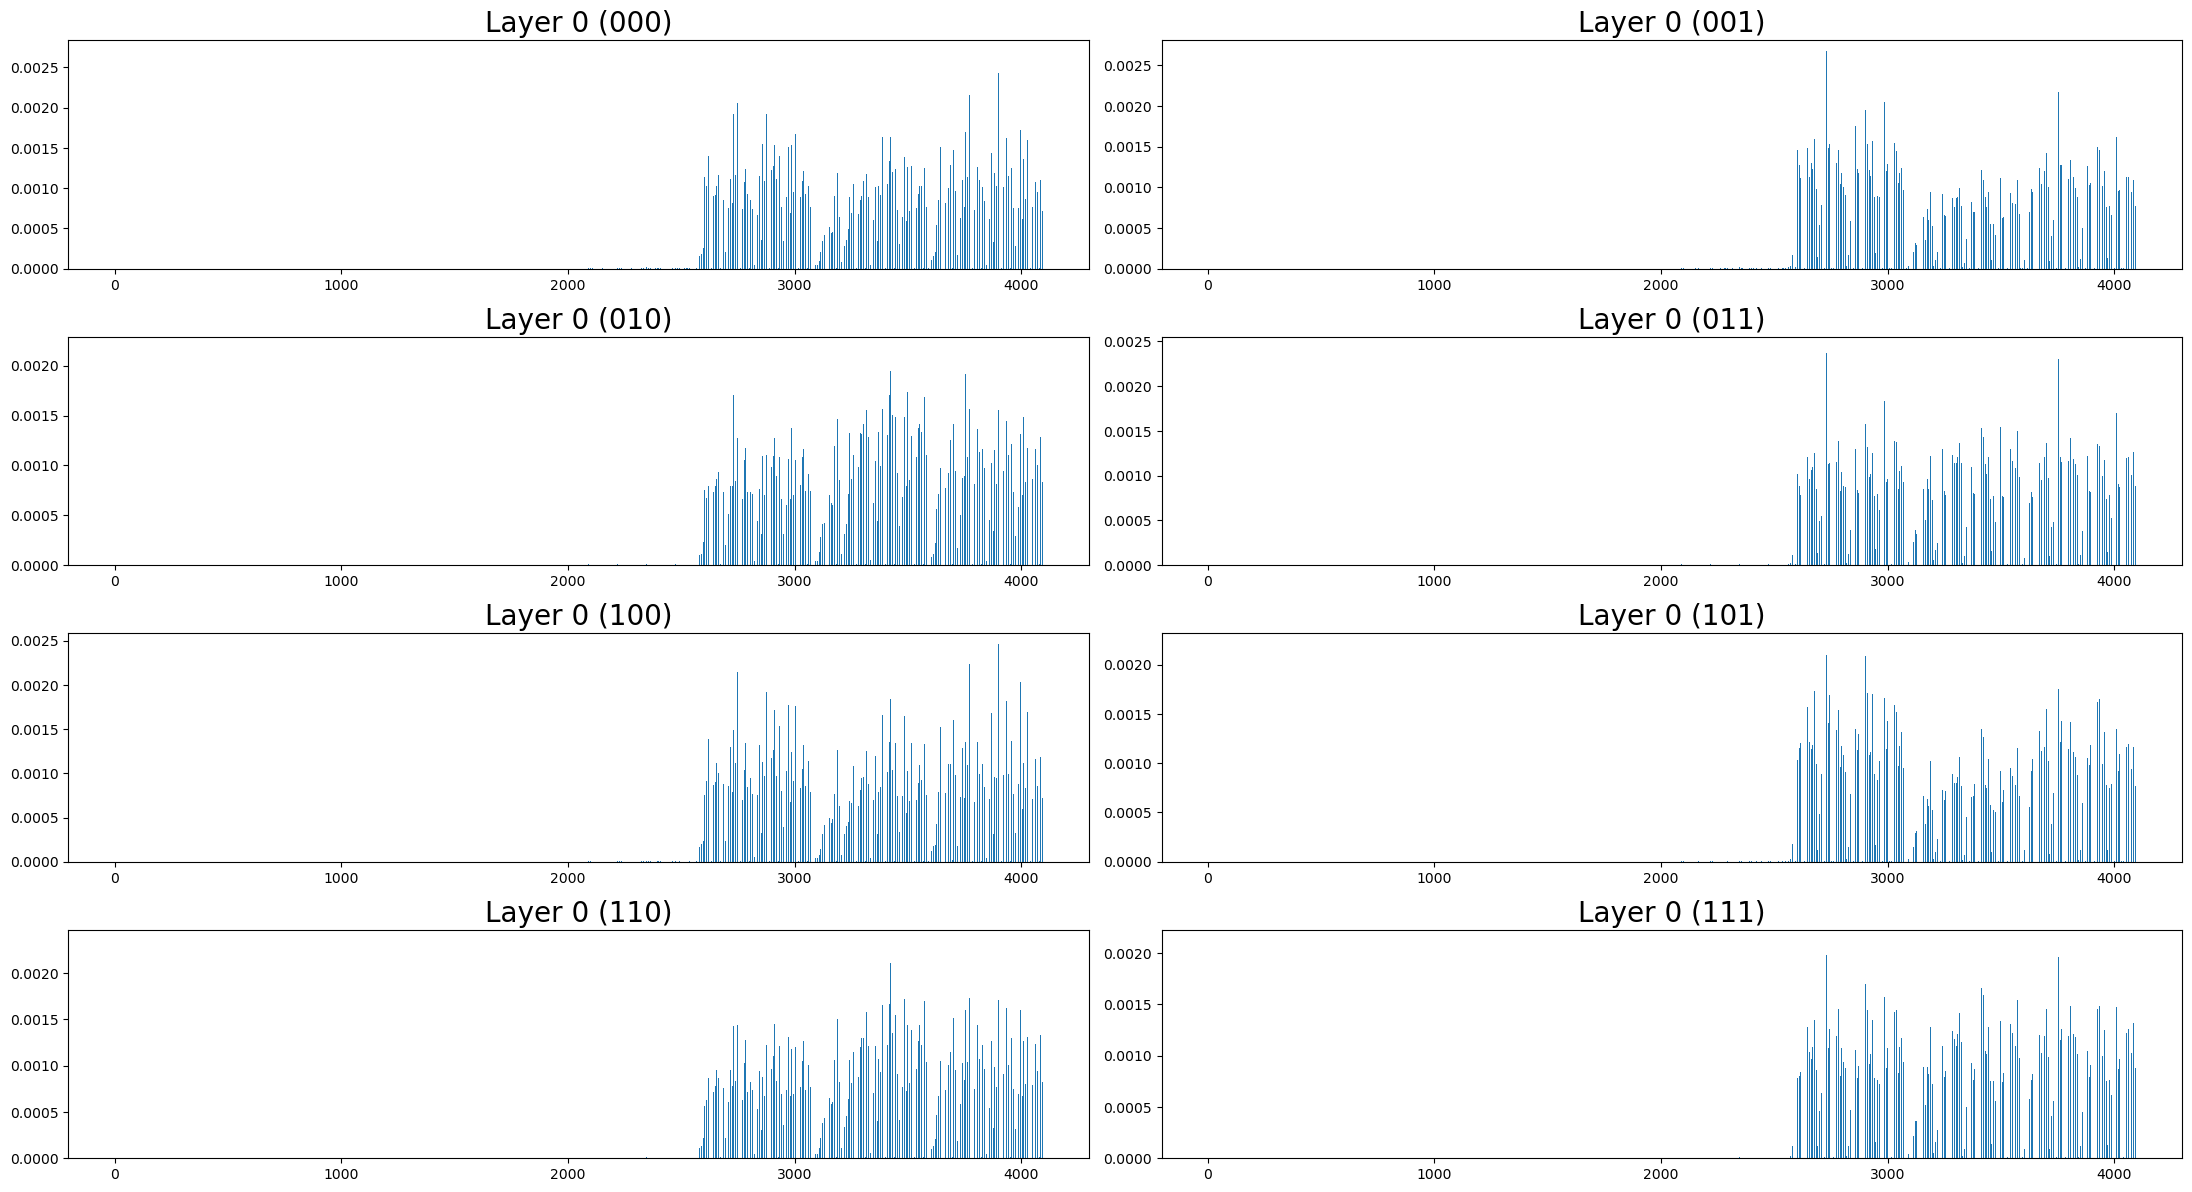

In [145]:
fig, ax = plt.subplots(int(len(cause_indices)/2+0.5), 2, figsize=(22, 12))
# fig.suptitle("Causal Distributions",fontsize=25)
i = cause_layer-4
for j in range(len(cause_indices)):
    dist = causal_dist['Layer '+str(i)+': dist'][j,:]
    row_ind = int(j/2)
    col_ind = j%2
    ax[row_ind, col_ind].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.5,align='edge',label = "Data Distribution")
    ax[row_ind, col_ind].set_title("Layer "+str(i)+' ('+''.join(bnr[:,j].reshape(n_dz[cause_layer],).astype(str))+')',fontsize=20)
plt.tight_layout(pad=1)    
plt.show()

In [293]:
anti_data_dist = (data_dist == 0).long()/(data_dist == 0).long().sum()
anti_data_dist

tensor([0.0003, 0.0003, 0.0003,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')

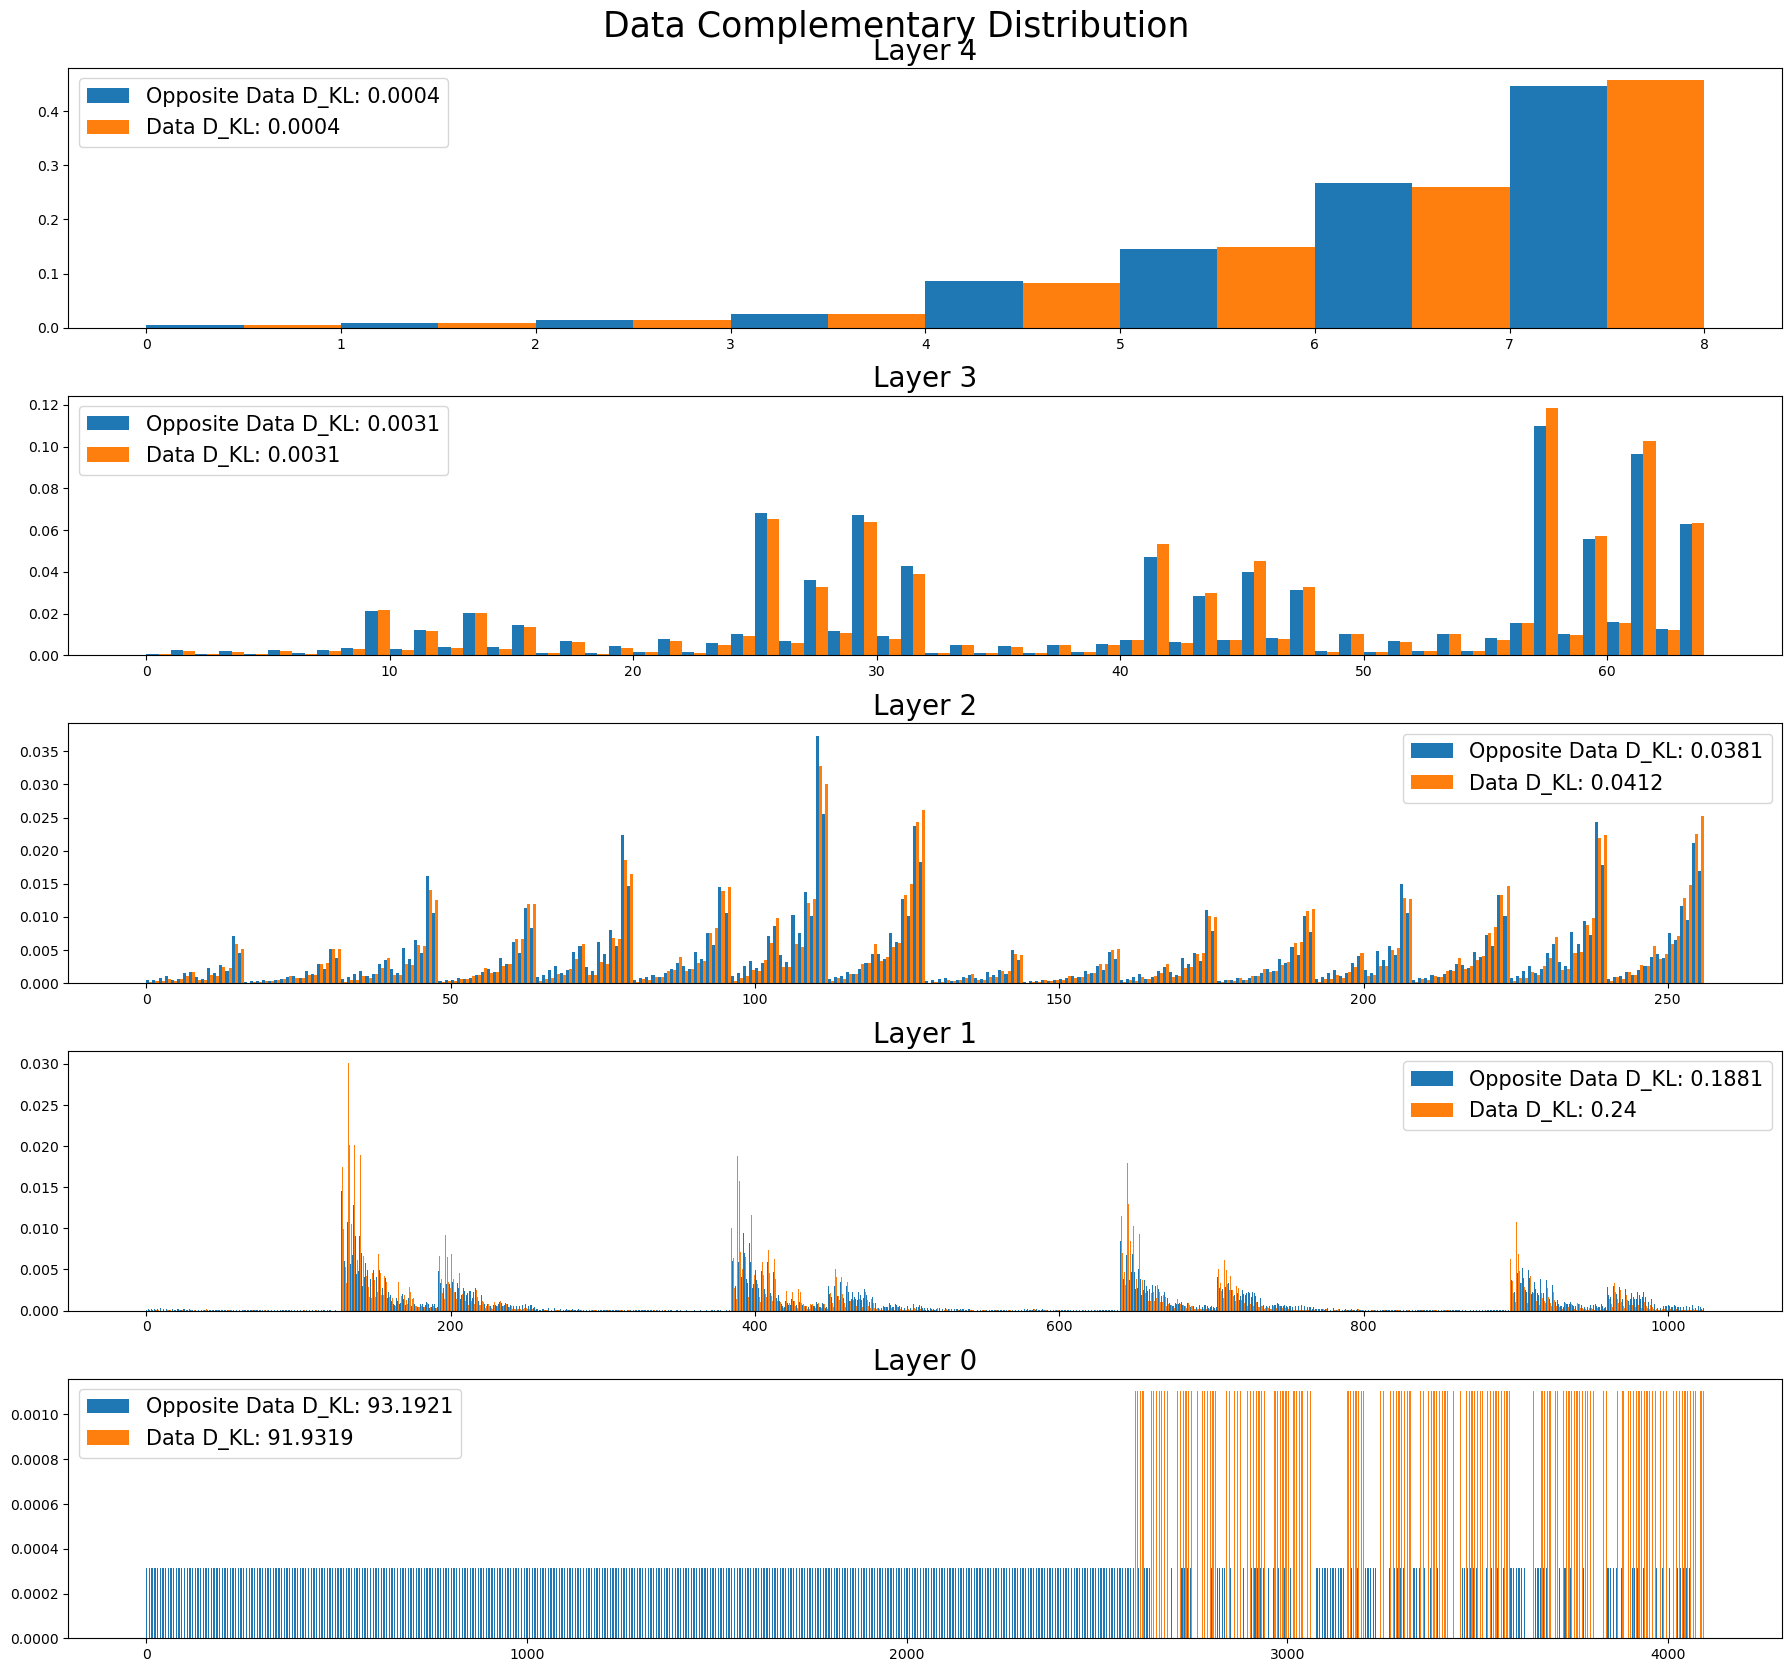

In [300]:
fig, ax = plt.subplots(n_layer-1, 1, figsize=(18, 17))
fig.suptitle("Data Complementary Distribution",fontsize=25)
dist_ct_pre = anti_data_dist
for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    D_KL_opp = KL_divergence(dist_w, dist_ct_pre).item()
    D_KL = KL_divergence(dist_ct_pre,dist_w).item()
    
    ax[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_ct_pre.to('cpu').numpy(),width=0.5,align='edge',\
                        label='Opposite Data D_KL: '+ str(np.around(D_KL_opp,4)))
    ax[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                        label = "Data D_KL: "+ str(np.around(D_KL,4)))
    ax[n_layer-2-i].set_title("Layer "+str(i),fontsize=20)
    ax[n_layer-2-i].legend(fontsize=15)
    
    if i < n_layer-2:
        prob_ft, prob_ct = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        dist_ct_pre = torch.matmul(dist_ct_pre, prob_ct)
    
plt.tight_layout(pad=1)    
plt.show()

### Plot Analytic

In [72]:
# Analytic_ws_batch['Index'] = Analytic_ws_batch.index

In [ ]:
# for i in range(len(col_list)):
#     Analytic_ws_batch.plot(x='Index',y=col_list[i],kind='line',legend=True)
# plt.close()

In [2]:
Analytic_ws_batch = pd.read_csv('Analytic_ws_batch.csv', sep=",")
Analytic_ws_batch

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Recog_D_KL_Layer_0,...,Recog_D_KL_Layer_3,Gen_H_Layer_3,Gen_I_Layer_3,Gen_D_KL_Layer_3,Recog_H_Layer_4,Recog_I_Layer_4,Recog_D_KL_Layer_4,Gen_H_Layer_4,Gen_I_Layer_4,Gen_D_KL_Layer_4
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,68.994232,...,0.000012,4.158881,9.536743e-07,0.000012,2.079438,9.536743e-07,0.000007,2.079439,0.0,0.000006
1,0.691468,0.693039,0.693183,0.693046,0.616928,0.692587,0.693104,0.693093,0.693318,33.012474,...,0.000131,4.158812,6.628036e-05,0.000130,2.079191,8.130074e-05,0.000086,2.079327,0.0,0.000085
2,0.689466,0.693011,0.693128,0.692630,0.614550,0.689150,0.693249,0.692969,0.693229,31.326004,...,0.000017,4.158498,1.745224e-04,0.000016,2.079260,9.799004e-05,0.000026,2.079244,0.0,0.000026
3,0.688073,0.693303,0.692915,0.693097,0.614205,0.686890,0.691830,0.692660,0.692917,30.740173,...,0.000145,4.158237,3.027916e-04,0.000145,2.079297,1.435280e-04,0.000003,2.079253,0.0,0.000003
4,0.684058,0.691606,0.692689,0.693507,0.614066,0.687006,0.691499,0.692571,0.692510,30.498985,...,0.000229,4.157988,3.771782e-04,0.000229,2.079173,1.442432e-04,0.000056,2.079008,0.0,0.000055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,0.265112,0.514316,0.487237,0.391851,0.345046,0.479688,0.557601,0.532164,0.466547,6.710065,...,0.000447,3.369449,1.912861e-01,0.000443,1.413319,1.907634e-01,0.000012,1.414092,0.0,0.000011
2197,0.260851,0.528620,0.500634,0.416142,0.350034,0.481594,0.563655,0.519253,0.465670,6.712999,...,0.000339,3.356569,1.914661e-01,0.000334,1.413210,1.898803e-01,0.000015,1.411132,0.0,0.000014
2198,0.273934,0.516208,0.486625,0.407732,0.346137,0.476487,0.565469,0.516958,0.478469,6.719982,...,0.000366,3.352261,1.908796e-01,0.000359,1.408082,1.892189e-01,0.000017,1.410681,0.0,0.000017
2199,0.273755,0.529722,0.496625,0.409228,0.346964,0.485345,0.562294,0.529739,0.471317,6.709084,...,0.000311,3.359583,1.914580e-01,0.000305,1.413376,1.904778e-01,0.000018,1.415845,0.0,0.000017


In [3]:
x = np.arange(len(Analytic_ws_batch))

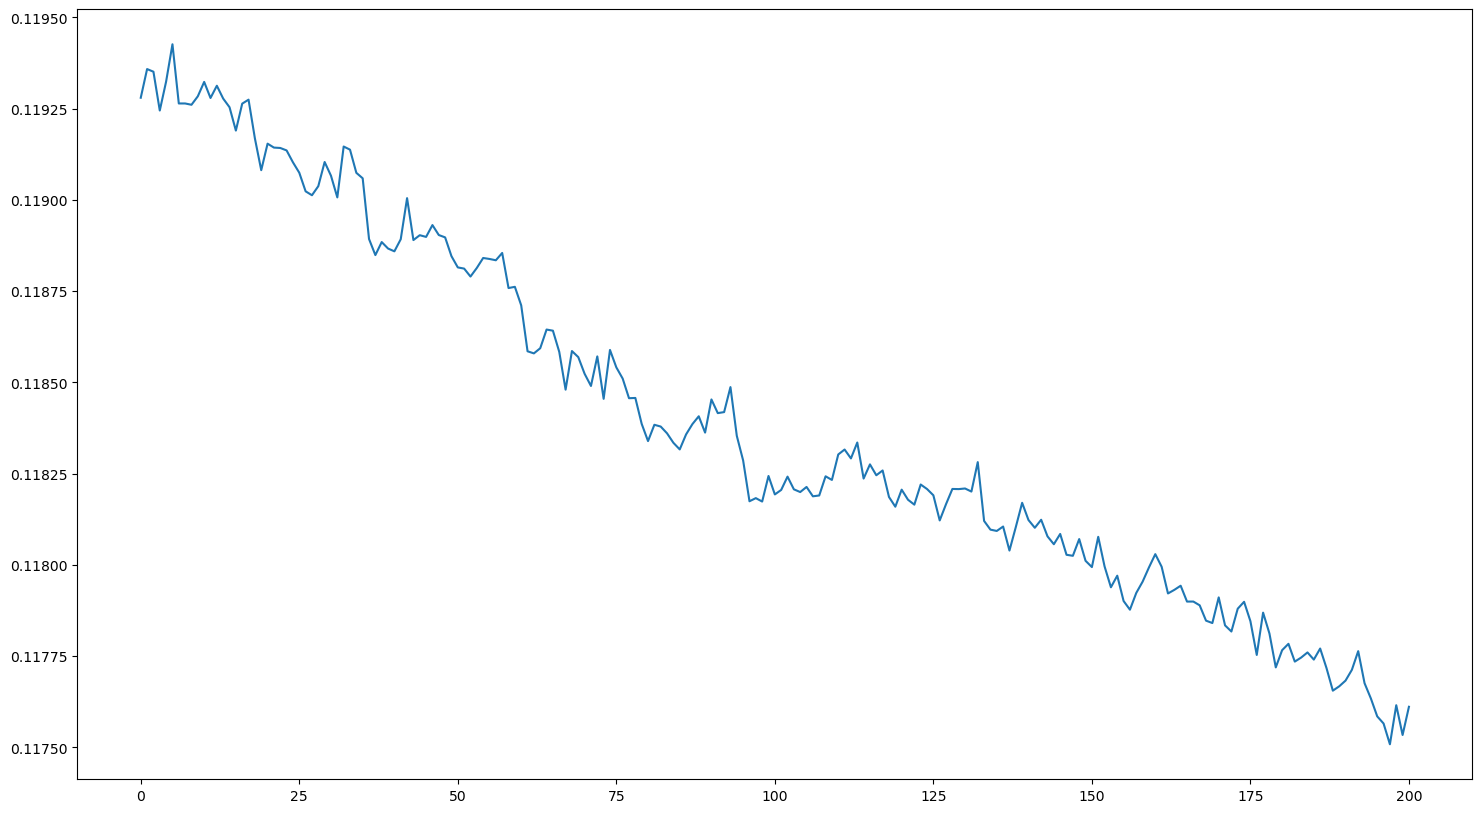

In [11]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic_ws_batch['Gen_D_KL_Layer_'+str(0)])[2000:])
plt.show()

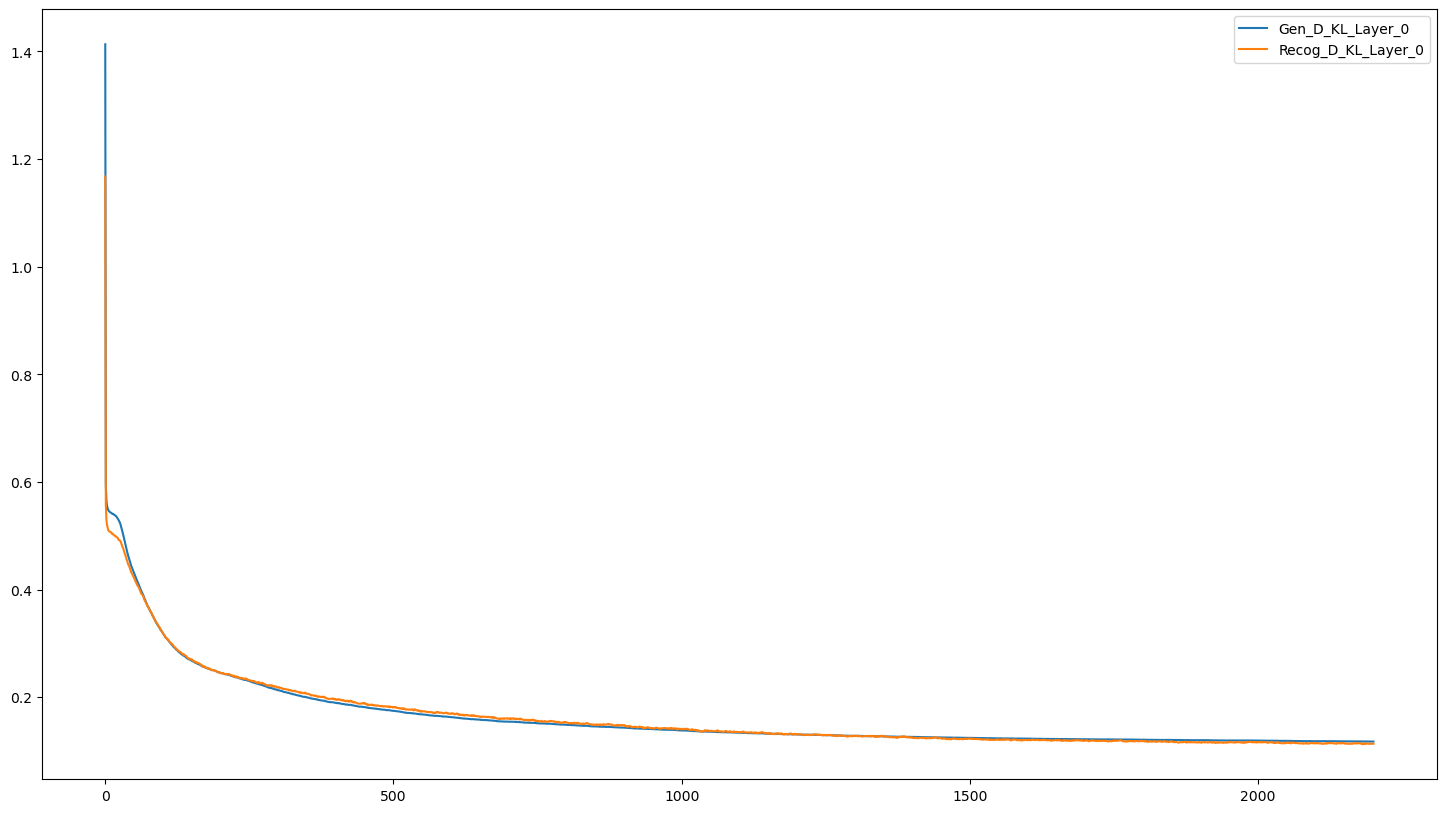

In [7]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, np.array(Analytic_ws_batch['Gen_D_KL_Layer_'+str(0)]),label = 'Gen_D_KL_Layer_'+str(0))
ax.plot(x, np.array(Analytic_ws_batch['Recog_D_KL_Layer_'+str(0)])/np.array(Analytic_ws_batch['Recog_D_KL_Layer_'+str(0)]).mean()*np.array(Analytic_ws_batch['Gen_D_KL_Layer_'+str(0)]).mean(),label = 'Recog_D_KL_Layer_'+str(0))
# ax.plot(x, np.array(Analytic_ws_batch['Recog_D_KL_Layer_'+str(0)]),label = 'Recog_D_KL_Layer_'+str(0))
ax.legend()
plt.show()

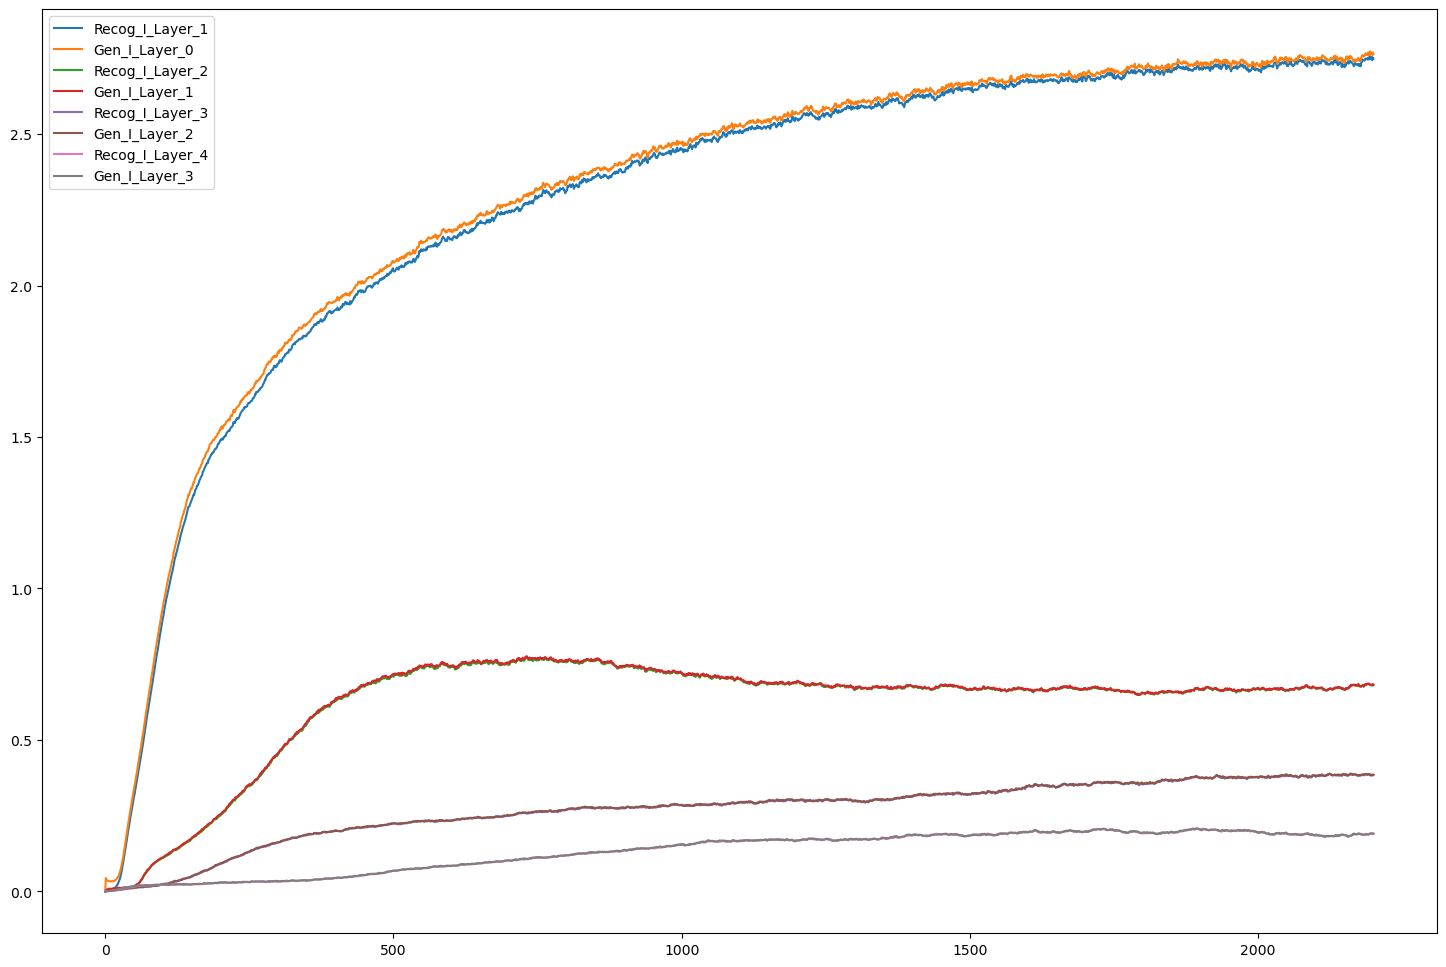

In [264]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(n_layer-2):
    ax.plot(x, np.array(Analytic_ws_batch['Recog_I_Layer_'+str(i+1)]),label = 'Recog_I_Layer_'+str(i+1))
    ax.plot(x, np.array(Analytic_ws_batch['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

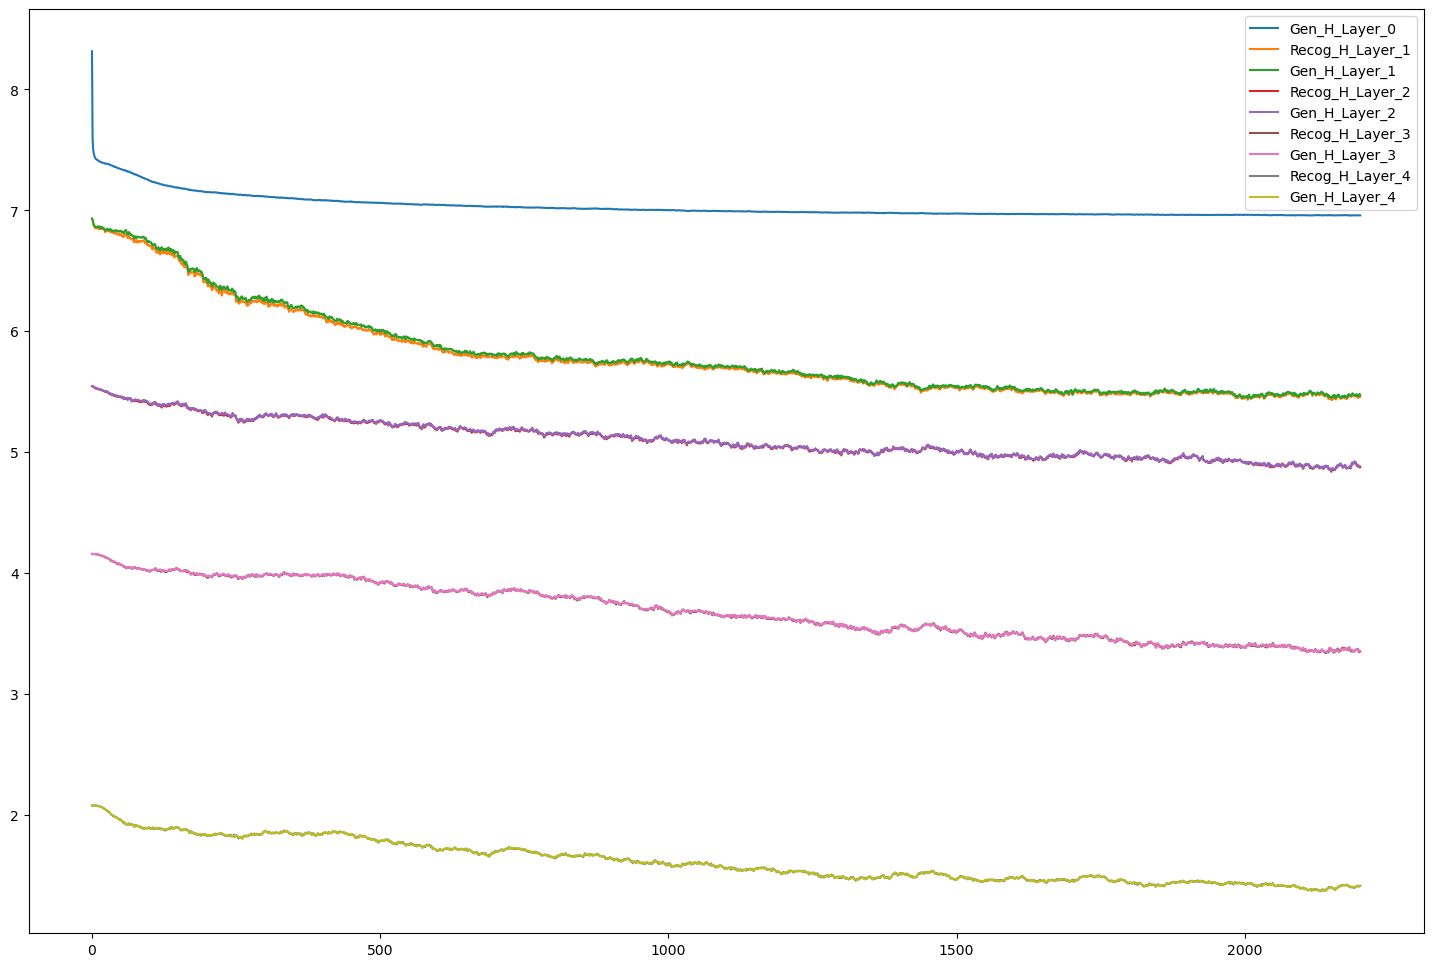

In [265]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(x, np.array(Analytic_ws_batch['Gen_H_Layer_'+str(0)]),label = 'Gen_H_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_batch['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_batch['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

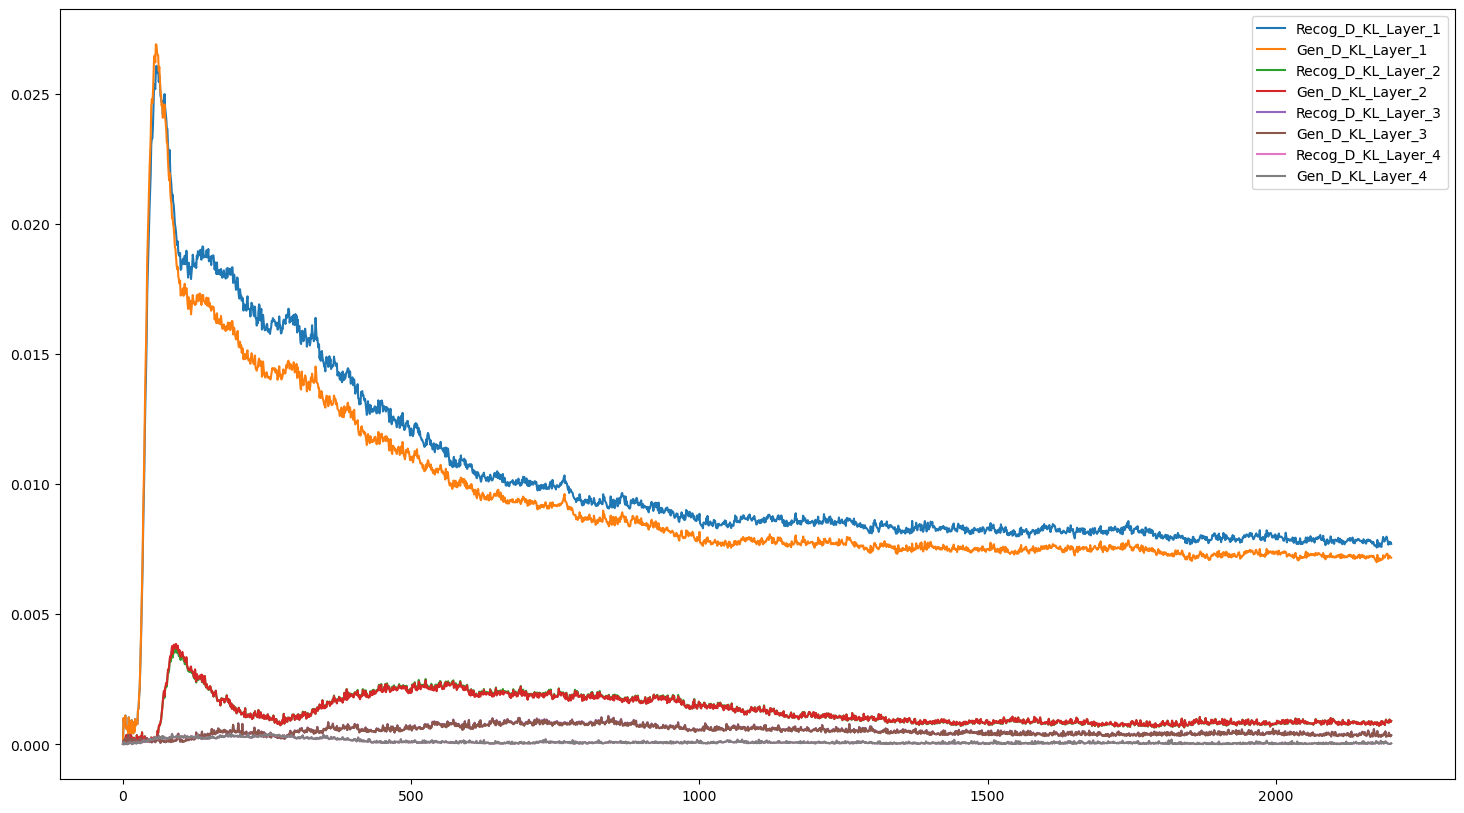

In [266]:
fig, ax = plt.subplots(figsize=(18, 10))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_batch['Recog_D_KL_Layer_'+str(i)]),label = 'Recog_D_KL_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_batch['Gen_D_KL_Layer_'+str(i)]),label = 'Gen_D_KL_Layer_'+str(i))
ax.legend()
plt.show()

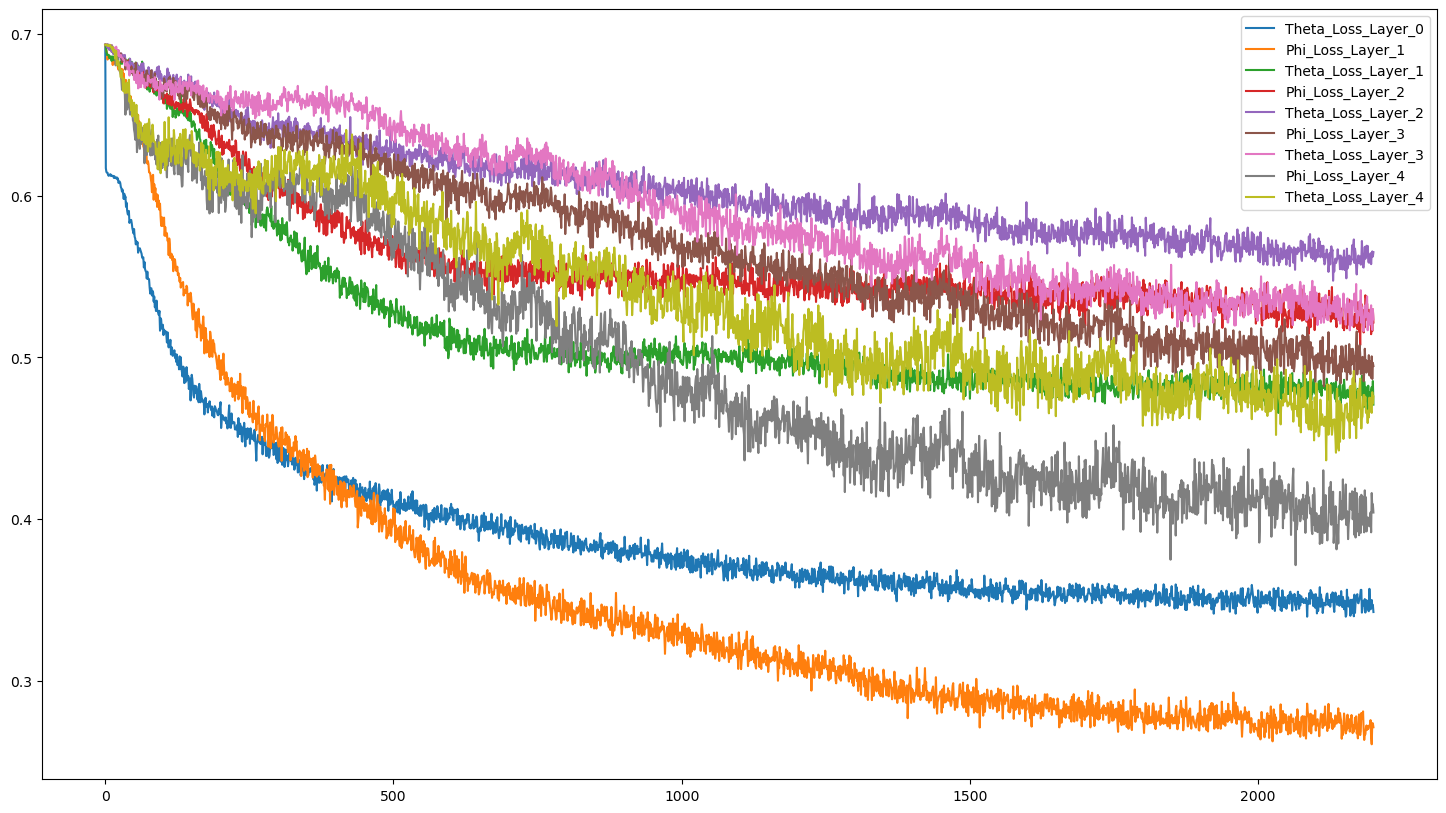

In [267]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, np.array(Analytic_ws_batch['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_batch['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_batch['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()

### Train with Predictive Processing

In [146]:
para = np.load('Parameters_ws_batch.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

In [147]:
def pp_dist(Theta,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    dev -- torch device
    Returns:
    pp_dict -- pp distribution dictionary, of length n_layer-1
    """
    pp_dict = {}
    dist_pre = torch.ones(1,device=dev)
    for i in range(len(Theta),0,-1):
        prob_ft, prob_ct = one_step_prob_matrix(n_dz[i], Theta["Theta_" + str(i) + str(i-1)],dev)
        dist_pre = torch.matmul(dist_pre,prob_ct)
        pp_dict['Layer_'+str(i-1)] = dist_pre
    return pp_dict

In [148]:
pp_dict = pp_dist(Theta,dev)

In [149]:
def ground_truth(dataset,dev):
    """
    Arguments:
    dataset -- data, torch tensor of shape (n_d,n_data)
    dev -- torch device
    Returns:
    data_dist -- data distribution. Torch tensor of shape (2**n_d,)
    """
    data_dcm = decimalize(dataset,dev)
    values_d,counts_d = torch.unique(data_dcm,return_counts=True)
    data_dist = torch.zeros(2**dataset.shape[0],device=dev)
    data_dist[values_d]=counts_d/dataset.shape[1]
    return data_dist

In [61]:
entire_set = binarilize(np.arange(2**n_d),n_d,dev)
entire_set

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 1,  ..., 0, 1, 1],
        [0, 1, 0,  ..., 1, 0, 1]], device='cuda:0')

In [150]:
def wake_dist_pp(Phi, data_dist, n_dz, pp_dict, dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data_dist -- data distribution with max entry as 1. Torch tensor of shape (2**n_d,)
    n_dz -- Helmholtz machine structure. Torch tensor of shape (n_layer,)
    pp_dict -- pp distribution dictionary, of length n_layer-1
    dev -- torch device
    Returns:
    
    """
    cause_dist = {}
    cause_dist_pp = {}
    dist_pre = data_dist
    cause_dist['Layer_0'] = dist_pre
    dist_pre_pp = data_dist * pp_dict['Layer_0']
    dist_pre_pp = dist_pre_pp/dist_pre_pp.sum()
    cause_dist_pp['Layer_0'] = dist_pre_pp
    for i in range(n_layer-2):
        prob_ft, prob_ct = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        dist_pre = torch.matmul(dist_pre, prob_ct)
        cause_dist['Layer_'+str(i+1)] = dist_pre
        
        dist_pre_pp = torch.matmul(dist_pre_pp, prob_ct) * pp_dict['Layer_'+str(i+1)]
        dist_pre_pp = dist_pre_pp/dist_pre_pp.sum()
        cause_dist_pp['Layer_'+str(i+1)] = dist_pre_pp
    return cause_dist, cause_dist_pp

In [63]:
test_dist = ground_truth(entire_set,dev)
test_dist

tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0')

In [67]:
cause_dist, cause_dist_pp = wake_dist_pp(Phi, test_dist, n_dz, pp_dict, dev)

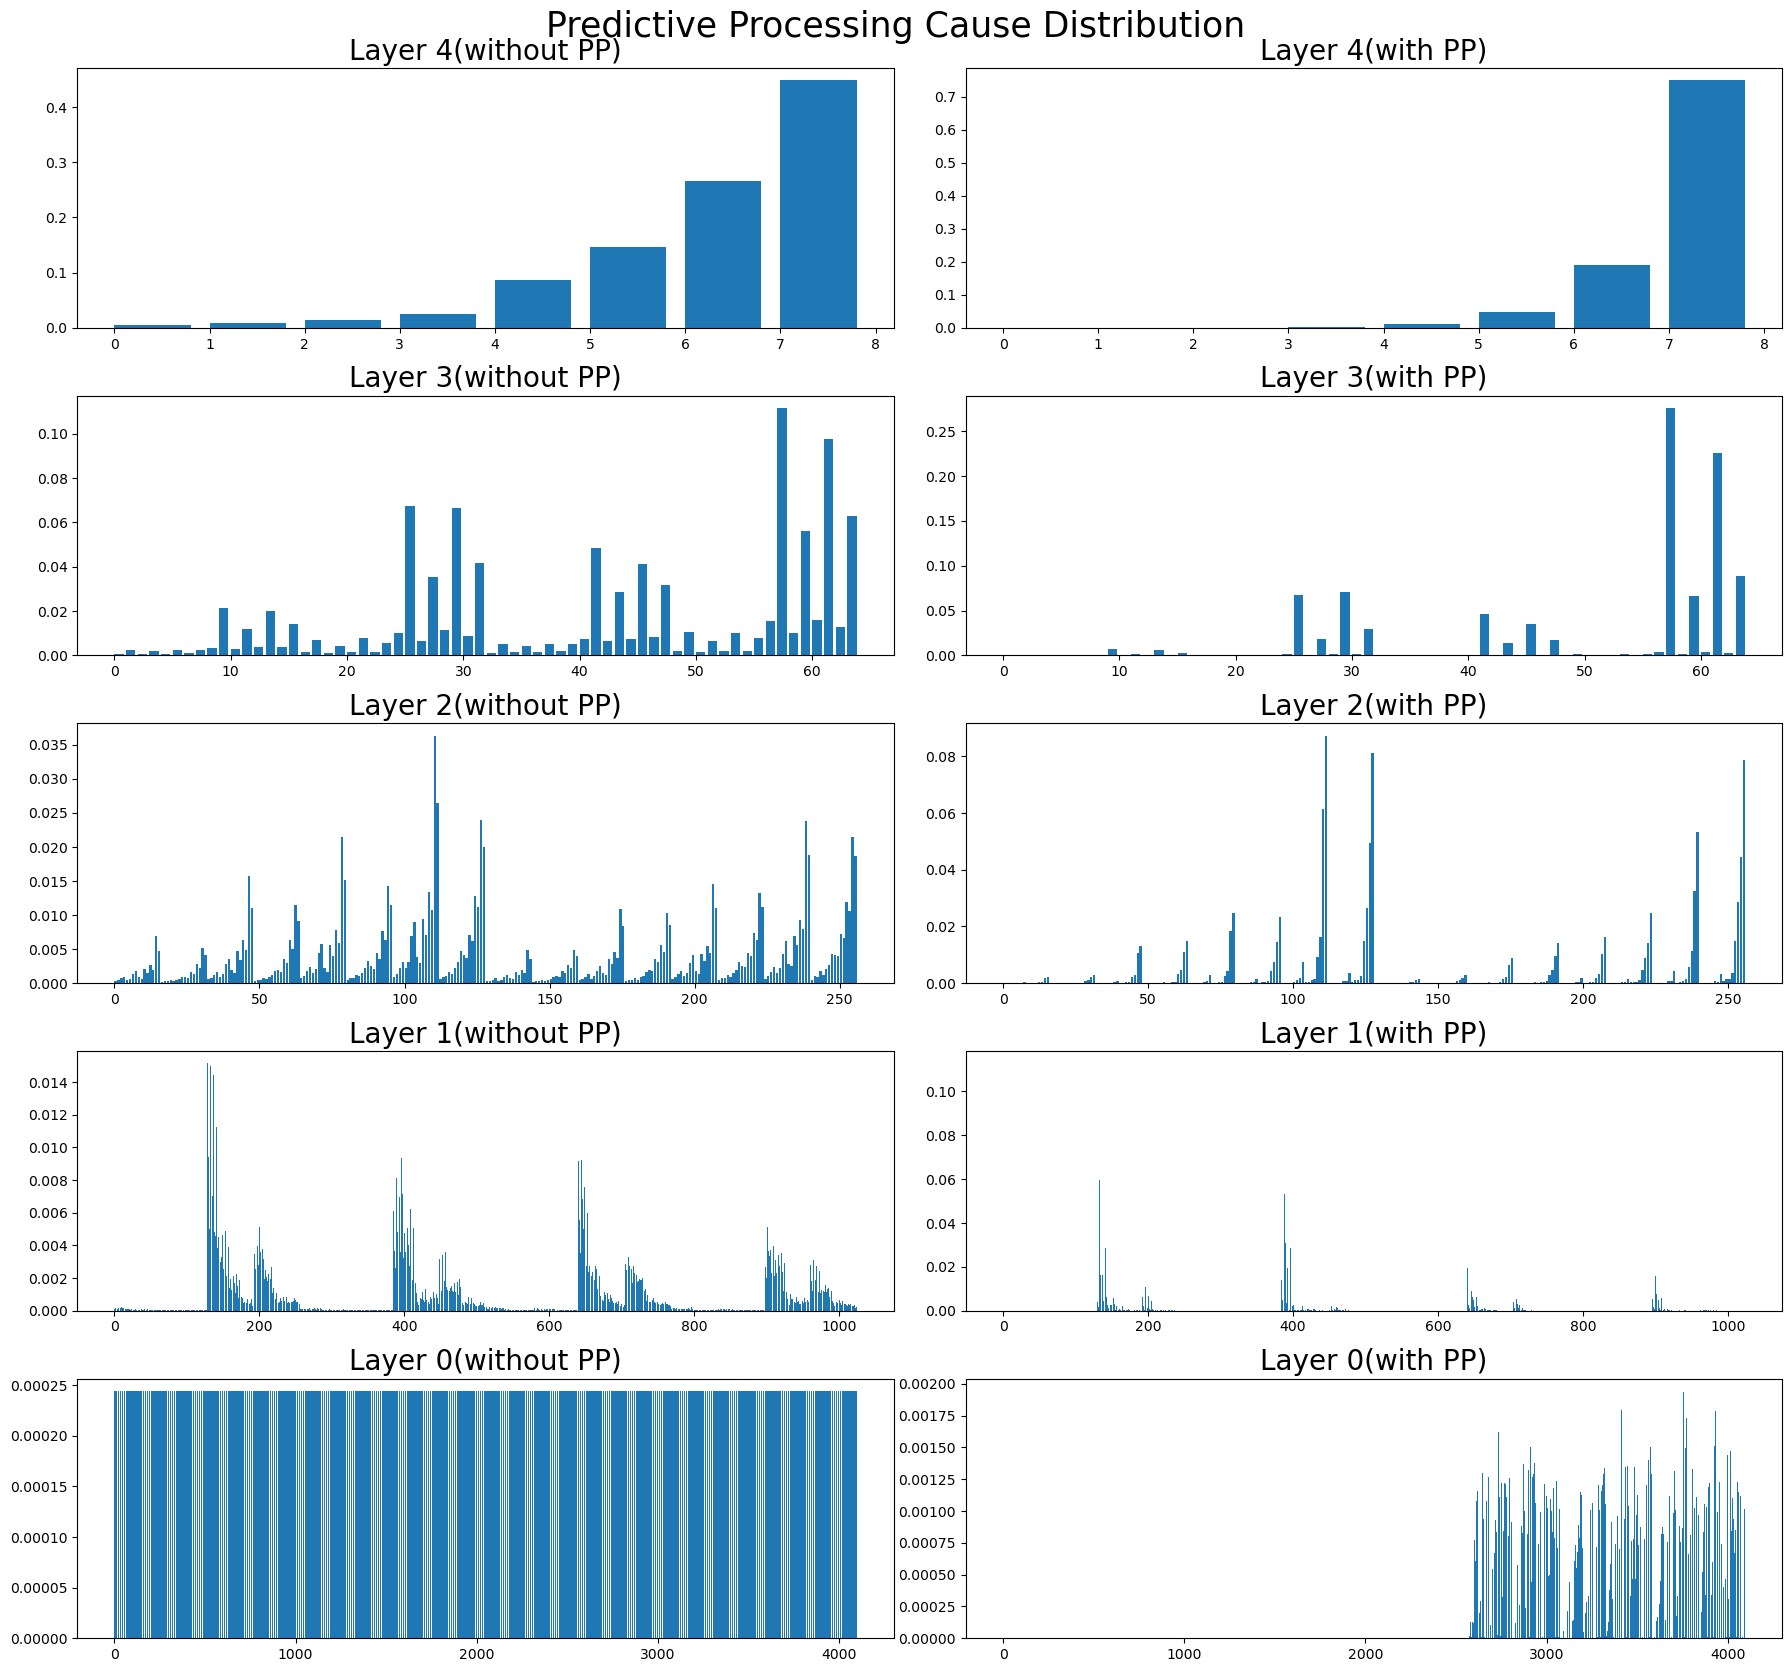

In [68]:
fig, ax = plt.subplots(n_layer-1, 2, figsize=(18, 17))
fig.suptitle("Predictive Processing Cause Distribution",fontsize=25)
for i in range(n_layer-1):
    dist = cause_dist['Layer_'+str(i)]
    dist_pp = cause_dist_pp['Layer_'+str(i)]
    
    ax[n_layer-2-i,0].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.8,align='edge')
    ax[n_layer-2-i,1].bar(np.arange(2**n_dz[i]),dist_pp.to('cpu').numpy(),width=0.8,align='edge')
    ax[n_layer-2-i,0].set_title("Layer "+str(i)+'(without PP)',fontsize=20)
    ax[n_layer-2-i,1].set_title("Layer "+str(i)+'(with PP)',fontsize=20)

plt.tight_layout(pad=1)    
plt.show()

In [43]:
test_dist = ground_truth(well_formed_set,dev)
test_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011], device='cuda:0')

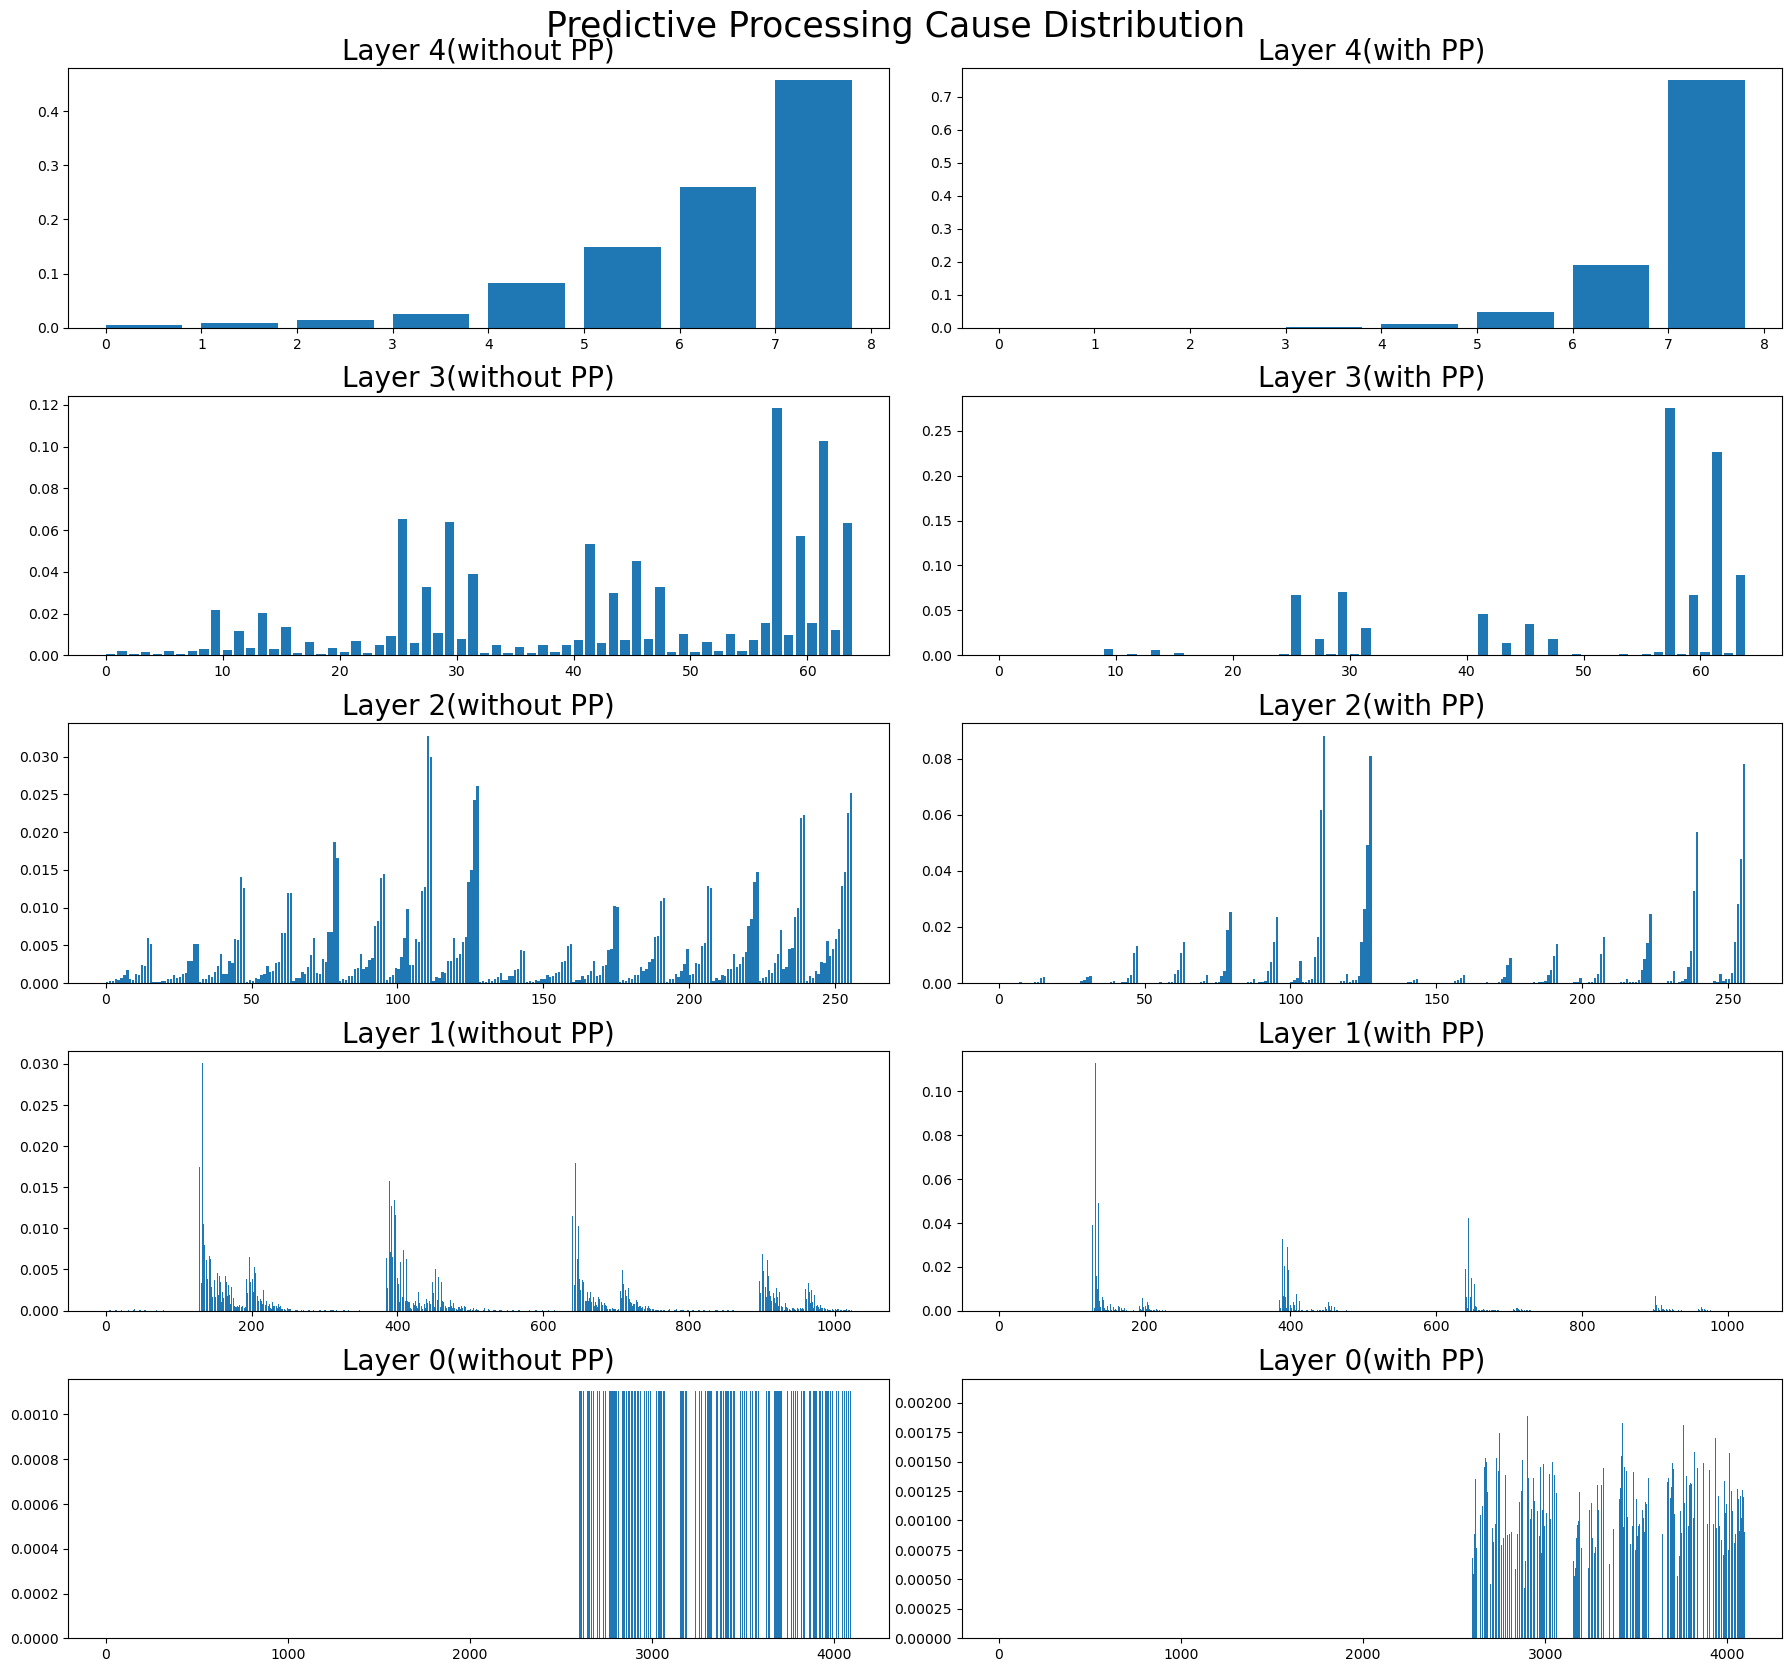

In [44]:
cause_dist, cause_dist_pp = wake_dist_pp(Phi, test_dist, n_dz, pp_dict, dev)
fig, ax = plt.subplots(n_layer-1, 2, figsize=(18, 17))
fig.suptitle("Predictive Processing Cause Distribution",fontsize=25)
for i in range(n_layer-1):
    dist = cause_dist['Layer_'+str(i)]
    dist_pp = cause_dist_pp['Layer_'+str(i)]
    
    ax[n_layer-2-i,0].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.8,align='edge')
    ax[n_layer-2-i,1].bar(np.arange(2**n_dz[i]),dist_pp.to('cpu').numpy(),width=0.8,align='edge')
    ax[n_layer-2-i,0].set_title("Layer "+str(i)+'(without PP)',fontsize=20)
    ax[n_layer-2-i,1].set_title("Layer "+str(i)+'(with PP)',fontsize=20)

plt.tight_layout(pad=1)    
plt.show()

In [45]:
# anti-data
data_dist = ground_truth(well_formed_set,dev)
test_dist = (data_dist == 0).long()/(data_dist == 0).long().sum()
test_dist

tensor([0.0003, 0.0003, 0.0003,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')

In [289]:
test_dist = torch.zeros(2**n_d,device=dev)
well_formed_dcm = decimalize(well_formed_set,dev)
test_dist[well_formed_dcm[100]] = 1

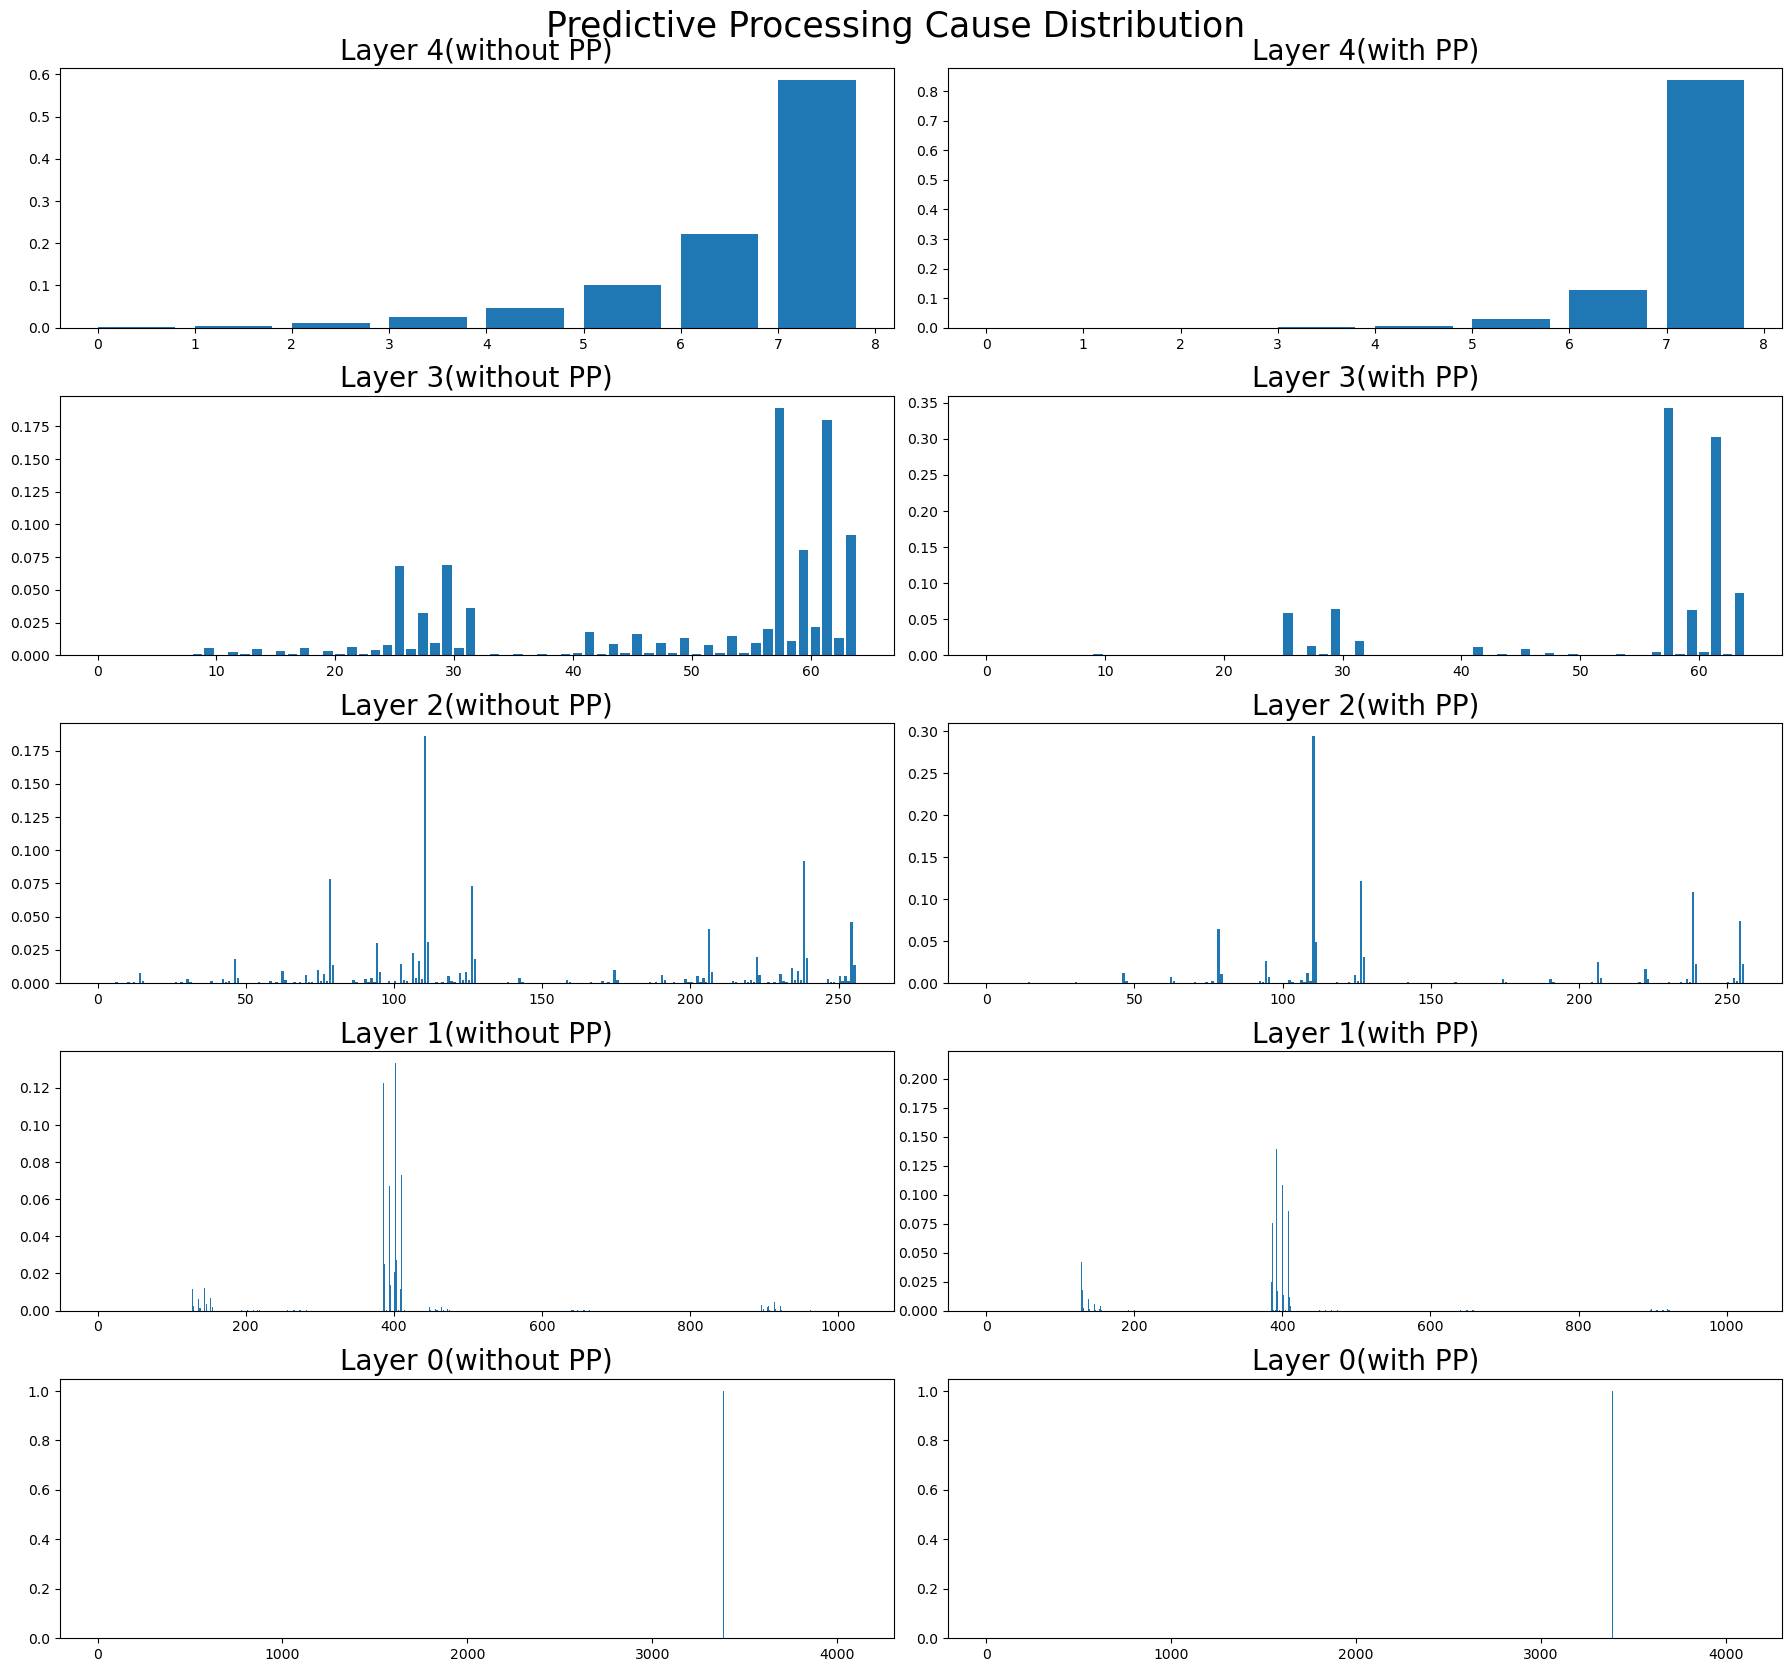

In [290]:
cause_dist, cause_dist_pp = wake_dist_pp(Phi, test_dist, n_dz, pp_dict, dev)
fig, ax = plt.subplots(n_layer-1, 2, figsize=(18, 17))
fig.suptitle("Predictive Processing Cause Distribution",fontsize=25)
for i in range(n_layer-1):
    dist = cause_dist['Layer_'+str(i)]
    dist_pp = cause_dist_pp['Layer_'+str(i)]
    
    if i > 0:
        ax[n_layer-2-i,0].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.8,align='edge')
        ax[n_layer-2-i,1].bar(np.arange(2**n_dz[i]),dist_pp.to('cpu').numpy(),width=0.8,align='edge')
    else:
        ax[n_layer-2-i,0].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=5,align='edge')
        ax[n_layer-2-i,1].bar(np.arange(2**n_dz[i]),dist_pp.to('cpu').numpy(),width=5,align='edge')
    ax[n_layer-2-i,0].set_title("Layer "+str(i)+'(without PP)',fontsize=20)
    ax[n_layer-2-i,1].set_title("Layer "+str(i)+'(with PP)',fontsize=20)

plt.tight_layout(pad=1)    
plt.show()

In [47]:
def random_generate(k,n,n_data):
    """
    The dataset is generated in a favor of Bayesian mixure of Gaussians. Given k mixture Gaussian components, we sample their 
    means u_1...u_k uniformly from [0,1]. Then we randomly assign each data to one of the components, and sample from its 
    Gaussian distribution (u_k, sigma). sigma is a hyperparameter, we default it to 1.
    
    The "Bayesian mixure of Gaussians" generation is just a way to generate dataset with non-singular distributions. The 
    generated data distribution is not identified with the mixure of Gaussian distributions that generated it. In other words, 
    the data is treated as sole evidence without any prior on how it's been generated thus its reconstruction is not convolved 
    with it's generative distributions, which is a major difference from varietional inference.
        
    Arguments:
    k -- number of Gaussian components
    n -- length of input layer (single data point)
    n_data -- number of datapoints to generate
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    
    Returns:
    random_set -- generated dataset, numpy array of shape (n,n_data), n_data is the number of datapoints in the generated dataset
    """
    u = np.random.rand(n,k)
    c = np.random.randint(k, size=(n_data,))
    data_mean = u[:,c]
    prob = np.random.randn(n,n_data) + data_mean
    random_set = (prob>0.5).astype(int)
    
    values_c, counts_c = np.unique(c,return_counts=True)
    component_p = counts_c/n_data
    
    return random_set,u,component_p

In [49]:
random_set,u,component_p = random_generate(5,n_d,n_data)
random_set = torch.from_numpy(random_set).type(torch.int64).to(dev)
random_set

tensor([[1, 1, 1,  ..., 0, 1, 0],
        [0, 1, 1,  ..., 0, 1, 0],
        [1, 0, 0,  ..., 1, 1, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 1],
        [1, 1, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 1, 0]], device='cuda:0')

### Learn random set with PP

In [211]:
para = np.load('Parameters_ws_batch.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']
org_Dist = pp_dist(Theta,dev)

In [152]:
def cat_prob(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    prob_ct -- categorical probability, torch tensor of shape (2**n_y,batch_size)
    """
    n_y = q.shape[0]
    batch_size = q.shape[1]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_y, batch_size, device=dev)
    for i in range(batch_size):
        prob_ct[:,i] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    return prob_ct

In [153]:
def one_step_forward_pp(x, param, pp_dist,dev):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    pp_dist -- predictive distribution at output layer. Torch tensor of shape (2**n_y,)
    dev -- torch device
    
    Returns:
    precision -- weight of each sample at layer Y. Torch tensor of shape (batch_size,)
    sample_mtx -- sampled assignments at layer Y. Torch tensor of shape (n_y,batch_size)
    """
    n_y = param.shape[0]
    q = one_step_forward(x,param) # (n_y,batch_size)
    prob_ct = cat_prob(q)      # (2**n_y,batch_size)
    dist = prob_ct * pp_dist.reshape(-1,1)   # (2**n_y,batch_size)
    precision = dist.sum(axis=0)/dist.sum(axis=0).max() # (batch_size,)
    sample_index = torch.multinomial(dist.t(), 1).reshape(-1,)  # (batch_size,)
    sample_s = binarilize(sample_index,n_y,dev) # (n_y,batch_size)
    return precision, sample_s

In [154]:
def one_step_update_pp(x,y,param,precision,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    precision -- weight of each sample at layer Y. Torch tensor of shape (batch_size,)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul((q-y)* precision.reshape(1,-1),torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [155]:
def layer_wise_train_pp(input_x,param_xy,param_yx,pp_dist,precision_prod,lr,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    pp_dist -- predictive distribution at output layer Y. Torch tensor of shape (2**n_y,)
    precision_prod -- product of precisions from previous layers. Torch tensor of shape (batch_size,)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    precision -- weight of each sample at layer Y. Torch tensor of shape (batch_size,)
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    precision_prod -- product of precisions from previous layers. Torch tensor of shape (batch_size,)
    """
    precision, output_y = one_step_forward_pp(input_x, param_xy, pp_dist,dev)
#     print('precision',precision)
    
    # train the opposite phase from x to y
    precision_prod = precision_prod * precision
    param_yx, grad, loss = one_step_update_pp(output_y,input_x,param_yx,precision_prod,lr)
    
    return output_y, param_yx, grad, loss, precision_prod

In [156]:
def wake_phase_pp(Phi,Theta,data,pp_dict,precision_data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    pp_dict -- pp distribution dictionary, of length n_layer-1
    precision_data -- precision weights of data points. Torch tensor of shape (batch_size,)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    precision_prod -- product of precisions from previous layers. Torch tensor of shape (batch_size,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    precision_prod = precision_data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i],precision_prod = layer_wise_train_pp(input_x,\
           Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],pp_dict['Layer_'+str(i+1)],precision_prod,lr,dev)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = one_step_update_pp(\
      torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],precision_prod,lr)
    return Theta, Loss, precision_prod

In [210]:
data = overlap_set
batch_num = 200
batch_size = int(data.shape[1]/batch_num)
lr = 0.1
epoch = 50
batch_size

6

In [212]:
pp_dict = pp_dist(Theta,dev)  # attention

In [ ]:
for e in range(epoch):
    data_perm = data[:,torch.randperm(data.size()[1])]
    data_dcm = decimalize(data_perm,dev)
    Loss_W = 0
    Loss_S = 0
    for i in range(batch_num):
        batch_set = data_perm[:,i*batch_size:(i+1)*batch_size]
        batch_set_dcm = data_dcm[i*batch_size:(i+1)*batch_size]
        precision_data = pp_dict['Layer_0'][batch_set_dcm]/pp_dict['Layer_0'][batch_set_dcm].max()
#         print('precision_data', precision_data)
        Theta, Loss_sleep,precision_prod = wake_phase_pp(Phi,Theta,batch_set,pp_dict,precision_data,lr,dev)
    #     print('precision_prod', precision_prod)
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/batch_num,'    Loss_sleep:',Loss_S/batch_num)

In [220]:
parameters = {'Phi': Phi, 'Theta': Theta}

In [221]:
np.save('Parameters_pp_batchnum200',parameters)

In [185]:
# para = np.load('Parameters_pp_batchnum10.npy',allow_pickle=True).item()
# Phi = para['Phi']
# Theta = para['Theta']

In [215]:
org_data = well_formed_set
new_data = overlap_set
org_data_dist = ground_truth(org_data,dev)
new_data_dist = ground_truth(new_data,dev)

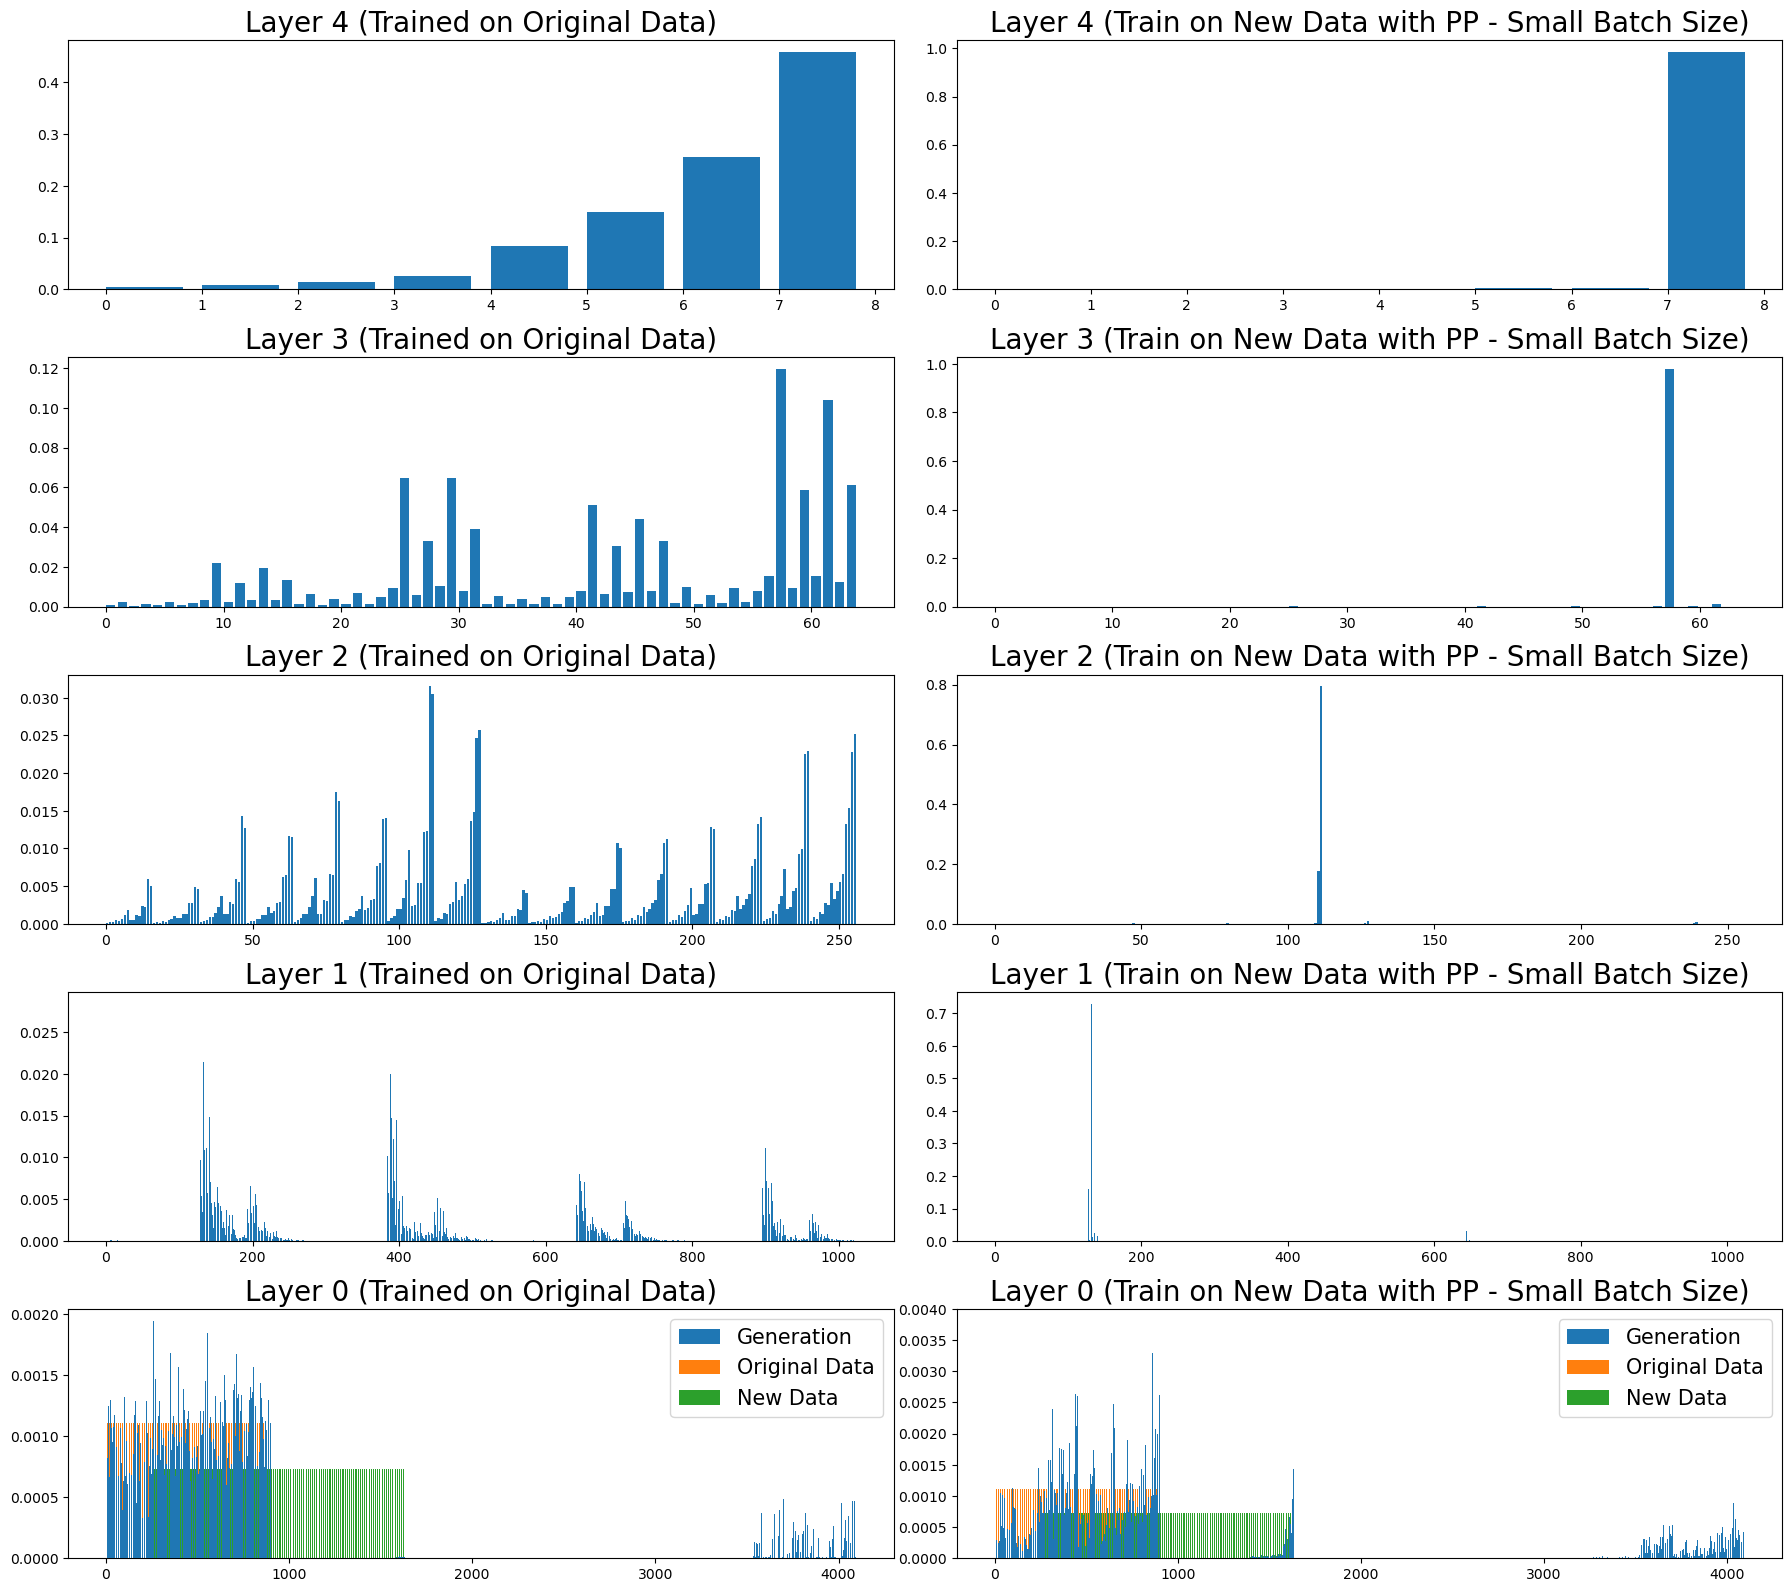

In [219]:
fig, ax = plt.subplots(n_layer-1, 2, figsize=(18, 16))
# fig.suptitle("Predictive Processing",fontsize=25)

dist_pre = torch.ones(1,device=dev)
for i in range(n_layer-1):
    dist_org = org_Dist['Layer_'+str(n_layer-2-i)]
    
    prob_ft, prob_ct = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    dist_pre = torch.matmul(dist_pre, prob_ct)
    dist_train = dist_pre
    if i < n_layer-2:
        ax[i,0].bar(np.arange(2**n_dz[n_layer-2-i]),dist_org.to('cpu').numpy(),width=0.8,align='edge')
        ax[i,1].bar(np.arange(2**n_dz[n_layer-2-i]),dist_train.to('cpu').numpy(),width=0.8,align='edge')
    else:
        ax[i,0].bar(np.arange(2**n_dz[n_layer-2-i]),dist_org[order].to('cpu').numpy(),width=0.8,align='edge',label='Generation',zorder=10)
        ax[i,1].bar(np.arange(2**n_dz[n_layer-2-i]),dist_train[order].to('cpu').numpy(),width=0.8,align='edge',label='Generation',zorder=10)
    ax[i,0].set_title("Layer "+str(n_layer-2-i)+' (Trained on Original Data)',fontsize=20)
    ax[i,1].set_title("Layer "+str(n_layer-2-i)+' (Train on New Data with PP - Small Batch Size)',fontsize=20)
    
ax[n_layer-2,0].bar(np.arange(2**n_dz[0]),org_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='Original Data',zorder=0)
ax[n_layer-2,0].bar(np.arange(2**n_dz[0])+0.5,new_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='New Data',zorder=5)
ax[n_layer-2,1].bar(np.arange(2**n_dz[0]),org_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='Original Data',zorder=0)
ax[n_layer-2,1].bar(np.arange(2**n_dz[0])+0.5,new_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='New Data',zorder=5)
ax[n_layer-2,1].set_ylim(0, 0.004)
ax[n_layer-2,0].legend(fontsize=15)
ax[n_layer-2,1].legend(fontsize=15)
plt.tight_layout(pad=1)    
plt.show()

In [188]:
precision_prod

tensor([9.2349e-02, 2.3781e-06, 2.9814e-07, 1.3963e-01, 1.0410e-06, 9.5505e-06,
        3.0785e-01, 5.8761e-04, 3.2596e-01, 2.8839e-01, 1.6465e-05, 4.9489e-01,
        1.0068e-06, 4.2877e-01, 2.3371e-01, 8.0174e-06, 4.2819e-06, 9.6814e-04,
        2.4698e-06, 7.4286e-07, 7.8737e-02, 1.0430e-01, 1.6018e-06, 5.9917e-07,
        4.0788e-01, 3.0534e-01, 1.6426e-06, 8.7362e-04, 5.2700e-05, 5.7409e-02,
        1.0100e-01, 6.6042e-02, 3.4908e-01, 4.5322e-01, 1.5440e-05, 2.3845e-05,
        3.5474e-06, 4.0094e-01, 3.8659e-06, 2.8888e-01, 3.6615e-01, 3.4832e-05,
        1.4336e-06, 4.7064e-01, 1.5150e-06, 2.4559e-05, 4.2698e-06, 9.2662e-07,
        2.4876e-01, 2.0947e-01, 4.6557e-01, 5.2702e-02, 1.4968e-01, 1.3340e-04,
        1.6150e-07, 3.0057e-03, 1.0718e-05, 2.1759e-04, 1.2745e-01, 3.3523e-01,
        2.5088e-06, 3.8587e-06, 4.3343e-01, 1.2832e-04, 2.0702e-04, 2.6732e-06,
        5.5871e-07, 3.3444e-01, 4.7271e-06, 6.2045e-01, 9.7404e-04, 4.4324e-01,
        2.3563e-07, 1.1596e-01, 5.9675e-

### Train without PP

In [189]:
para = np.load('Parameters_ws_batch.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

In [190]:
data = overlap_set
n_data = data.shape[1]
n_data

1375

In [191]:
data_dcm = decimalize(data,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0007, 0.0007, 0.0007], device='cuda:0')

In [192]:
batch_size = n_data
lr = 0.1
epoch = 10000

In [ ]:
for e in range(epoch):
    Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev)
    Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
    print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)

In [204]:
wake_ft = {}
sleep_ft = {}
wake_ct = {}
sleep_ct = {}
wake_ct['Layer 0: dist'] = data_dist
wake_ct['Layer 0: H_Y'] = entropy(data_dist)
wake_ft['Layer 0: dist'] = data_dist_ft
wake_ft['Layer 0: H_Y'] = entropy_bernoulli(data_dist_ft)
dist_ct_pre_s = torch.ones(1,device=dev)
dist_ct_pre_w = data_dist
for i in range(n_layer-1):
    prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
    
    sleep_ft['Layer '+str(n_layer-2-i)+': dist'], sleep_ft['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ft['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ft(dist_ct_pre_s, prob_ft_s)
    dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']
    
    if i < n_layer-2:
        prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
        wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)

        wake_ft['Layer '+str(i+1)+': dist'], wake_ft['Layer '+str(i+1)+': H_Y'], \
        wake_ft['Layer '+str(i+1)+': H_YX'] = prob_matrix_ft(dist_ct_pre_w, prob_ft_w)
        dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']

Layer 0 Data_dist D_KL: 11.5573 H(Y): 7.2262
Layer 0 Gen_dist D_KL: 0.2002 H(Y): 7.512
Layer 1 Recognition Distribution D_KL: 0.0313 H(Y): 5.3468 H(Y|X): 2.0464 I_XY: 3.3004
Layer 1 Generative  Distribution D_KL: 0.0262 H(Y): 7.512 H(Y|X): 4.162 I_XY: 3.3501
Layer 2 Recognition Distribution D_KL: 0.0018 H(Y): 4.79 H(Y|X): 3.8606 I_XY: 0.9293
Layer 2 Generative  Distribution D_KL: 0.0018 H(Y): 5.3894 H(Y|X): 4.4546 I_XY: 0.9347
Layer 3 Recognition Distribution D_KL: 0.0006 H(Y): 3.2879 H(Y|X): 2.8492 I_XY: 0.4386
Layer 3 Generative  Distribution D_KL: 0.0006 H(Y): 4.7912 H(Y|X): 4.3538 I_XY: 0.4375
Layer 4 Recognition Distribution D_KL: 0.0 H(Y): 1.3043 H(Y|X): 1.1551 I_XY: 0.1491
Layer 4 Generative  Distribution D_KL: 0.0 H(Y): 3.2845 H(Y|X): 3.1343 I_XY: 0.1502


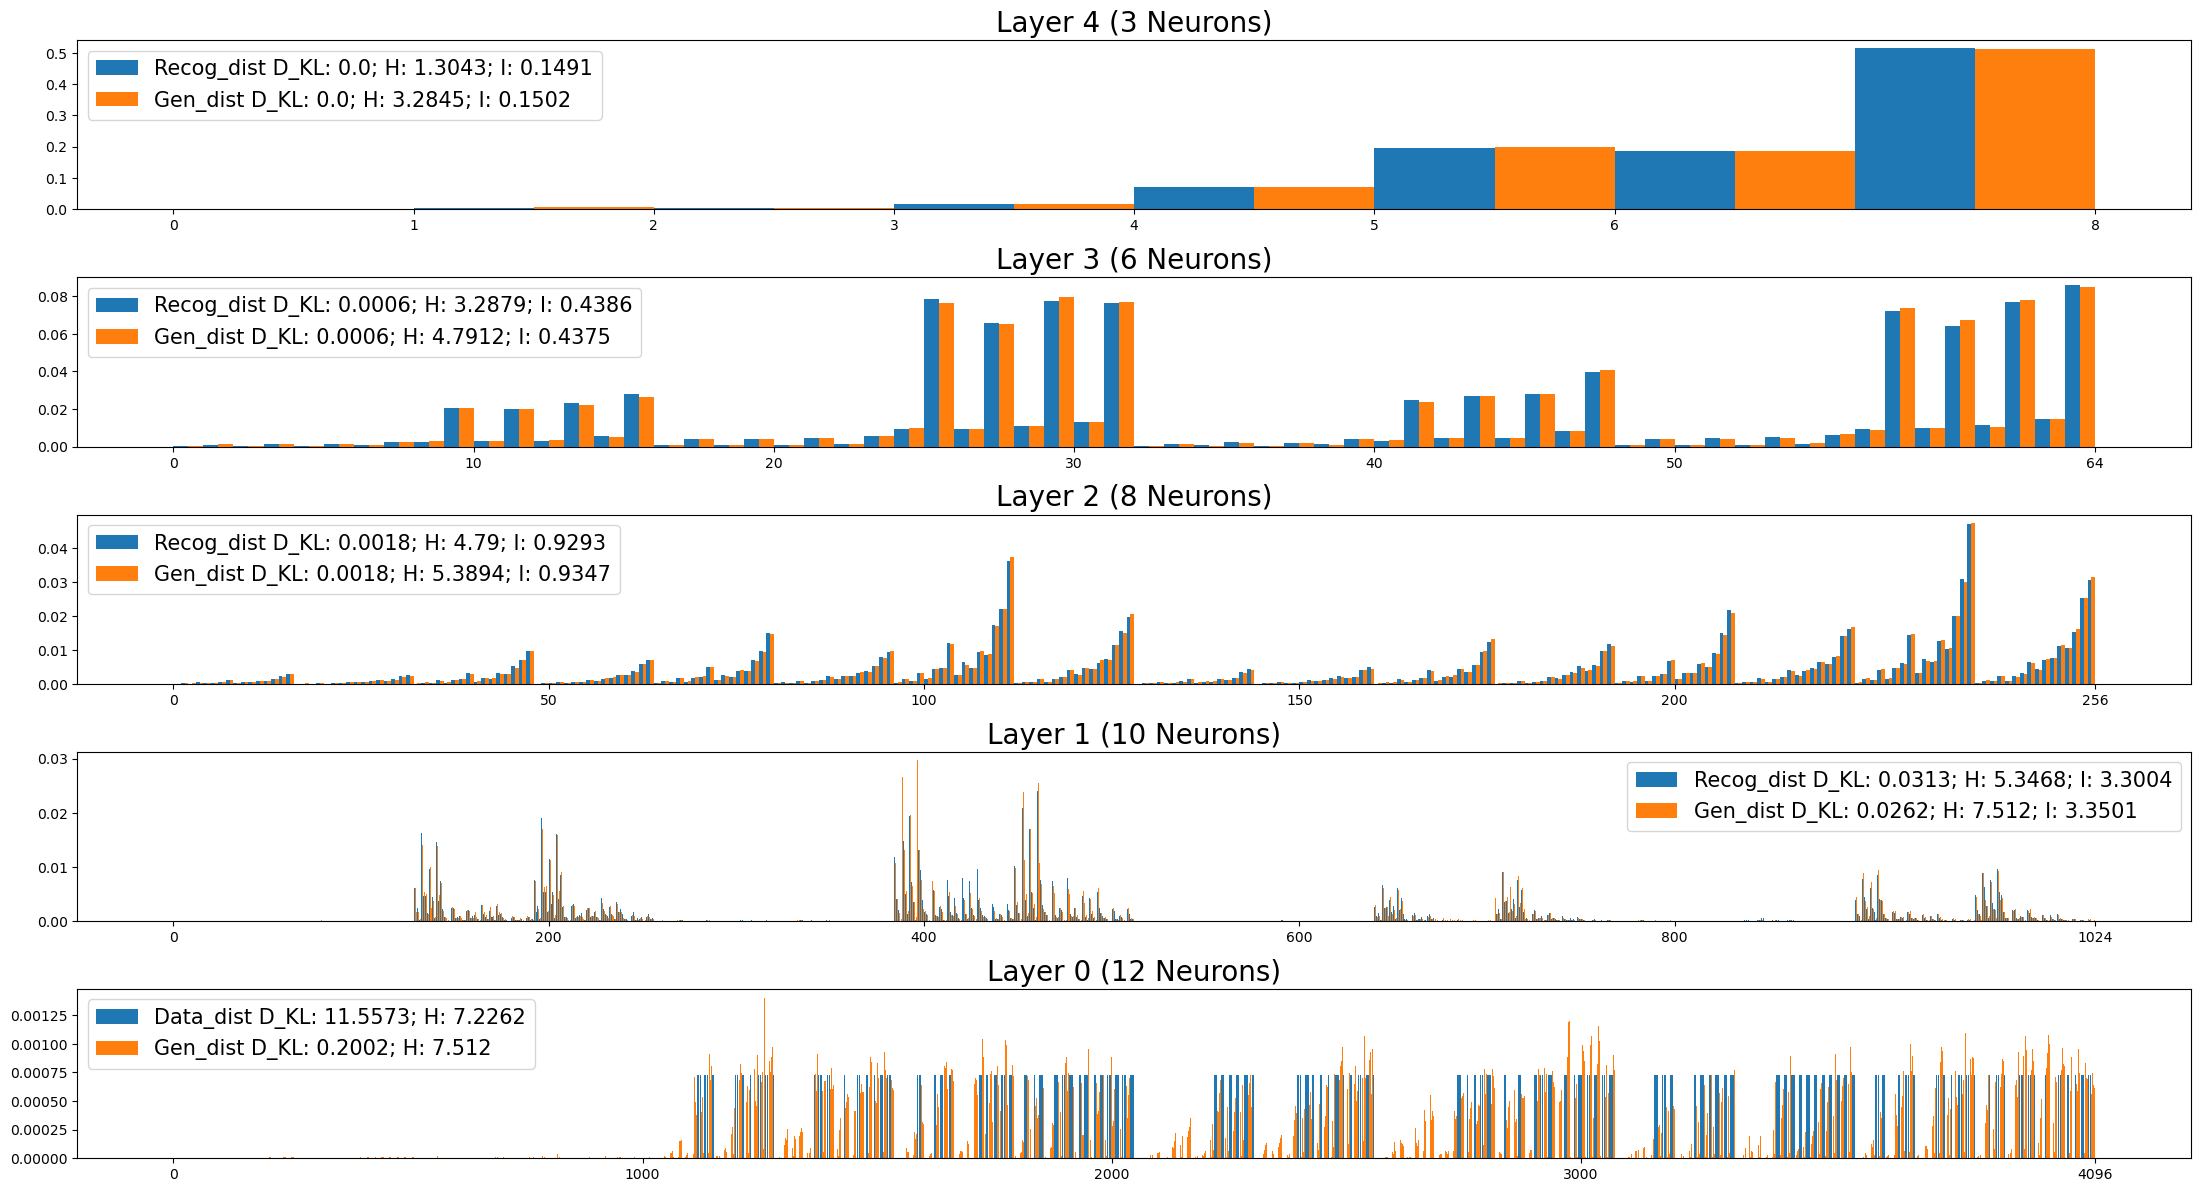

In [205]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 12))
# fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)

for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    dist_s = sleep_ct['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
    
        H_Y_s = sleep_ct['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ct['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
    x_lim = 2**(n_dz[n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)
    

plt.tight_layout(pad=1)    
plt.show()

In [201]:
org_data = well_formed_set
new_data = overlap_set
org_data_dist = ground_truth(org_data,dev)
new_data_dist = ground_truth(new_data,dev)

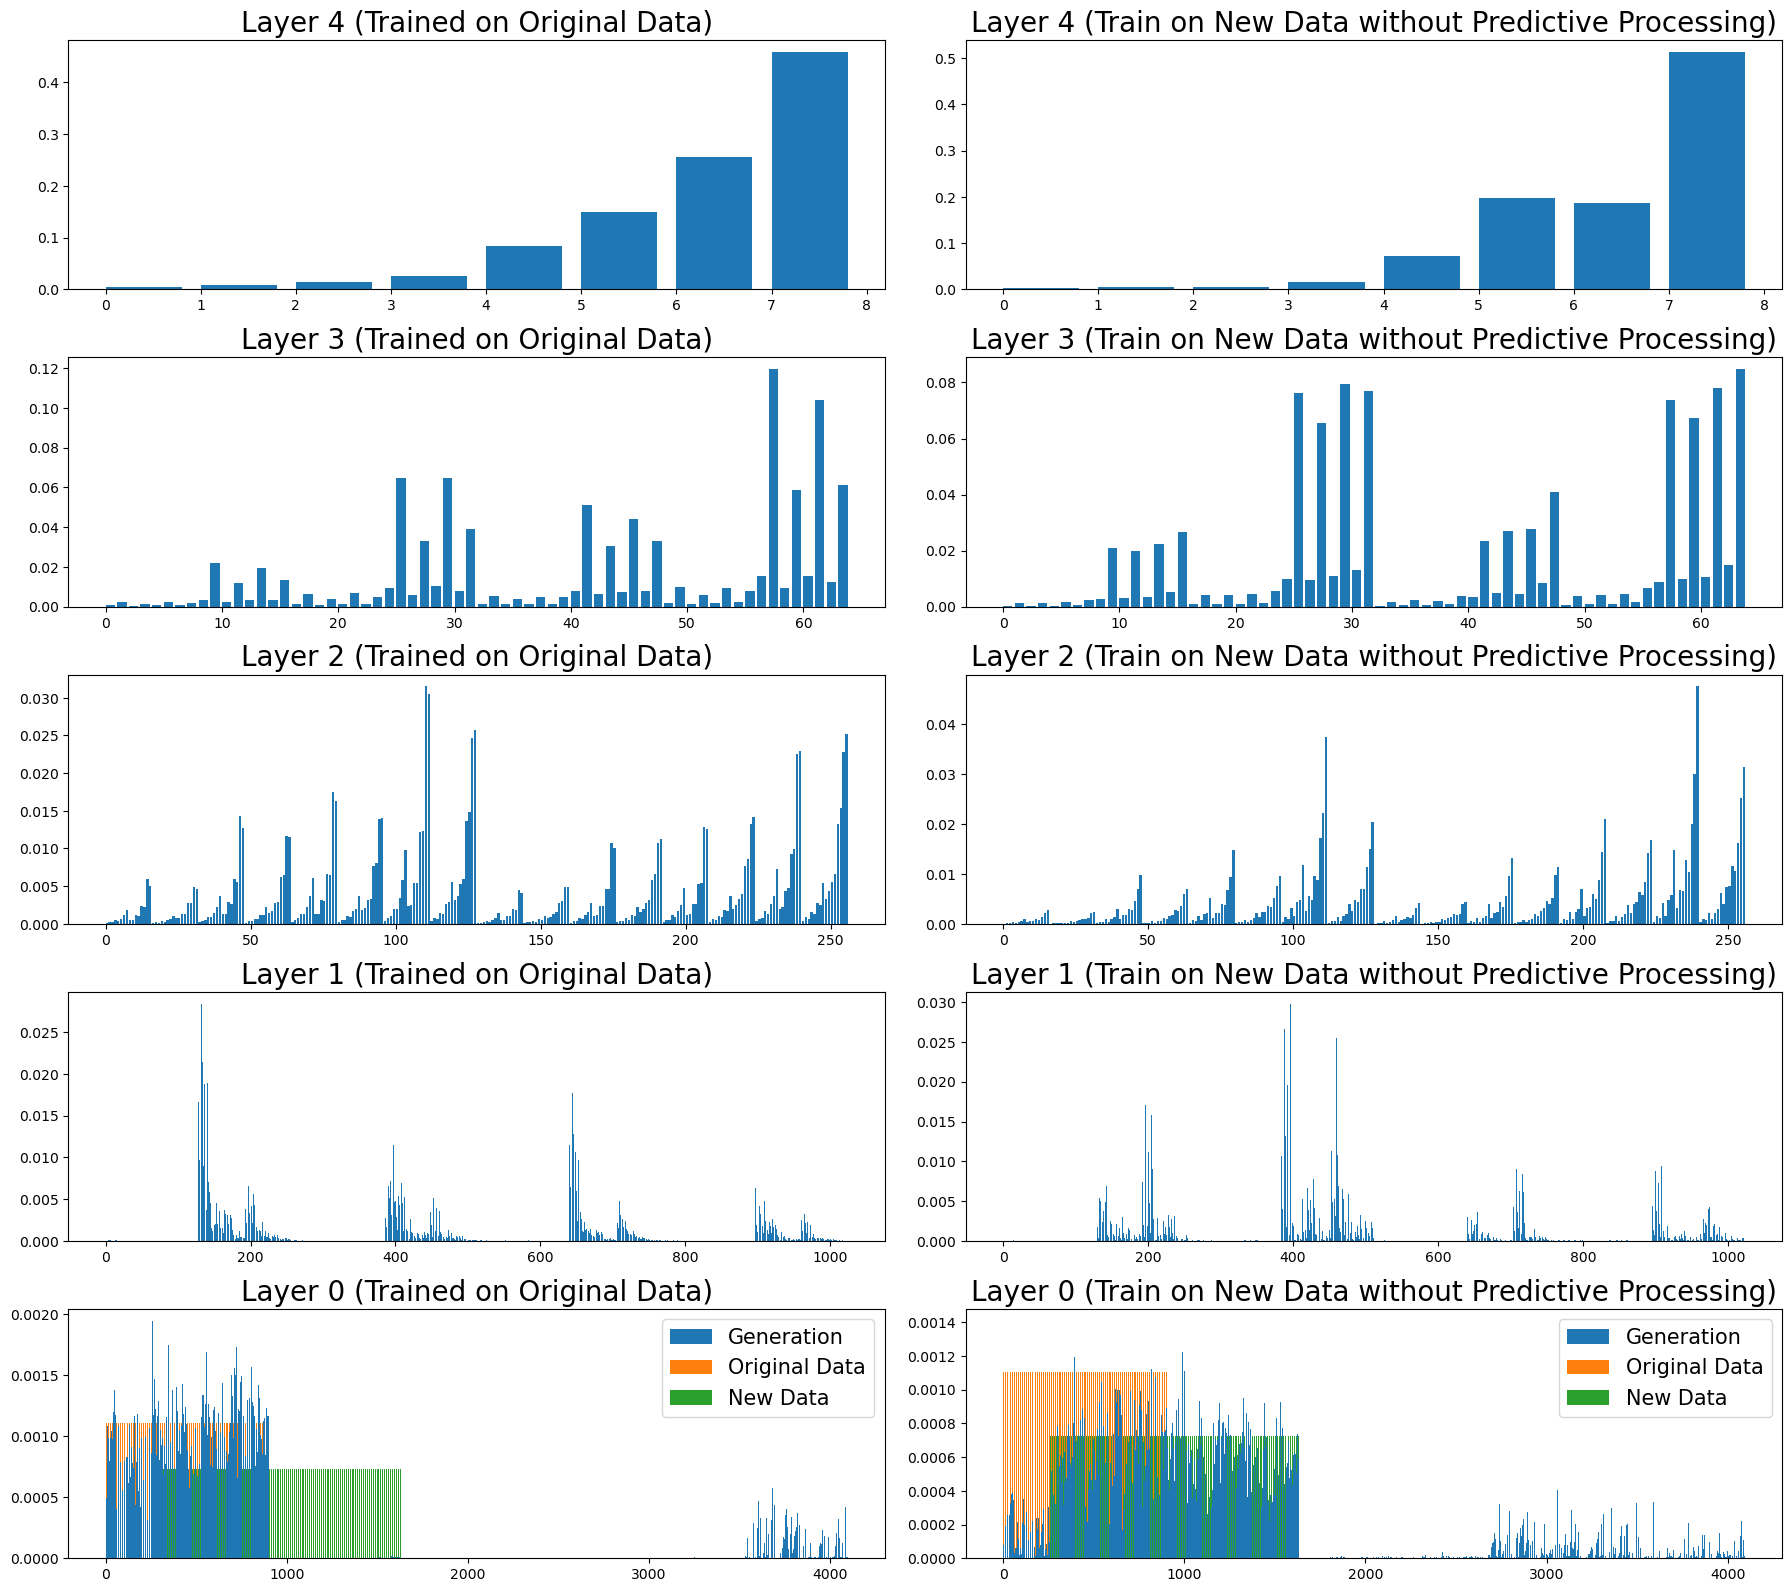

In [207]:
fig, ax = plt.subplots(n_layer-1, 2, figsize=(18, 16))
# fig.suptitle("Predictive Processing",fontsize=25)

dist_pre = torch.ones(1,device=dev)
for i in range(n_layer-1):
    dist_org = org_Dist['Layer_'+str(n_layer-2-i)]
    
    prob_ft, prob_ct = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    dist_pre = torch.matmul(dist_pre, prob_ct)
    dist_train = dist_pre
    if i < n_layer-2:
        ax[i,0].bar(np.arange(2**n_dz[n_layer-2-i]),dist_org.to('cpu').numpy(),width=0.8,align='edge')
        ax[i,1].bar(np.arange(2**n_dz[n_layer-2-i]),dist_train.to('cpu').numpy(),width=0.8,align='edge')
    else:
        ax[i,0].bar(np.arange(2**n_dz[n_layer-2-i]),dist_org[order].to('cpu').numpy(),width=0.8,align='edge',label='Generation',zorder=10)
        ax[i,1].bar(np.arange(2**n_dz[n_layer-2-i]),dist_train[order].to('cpu').numpy(),width=0.8,align='edge',label='Generation',zorder=10)
    ax[i,0].set_title("Layer "+str(n_layer-2-i)+' (Trained on Original Data)',fontsize=20)
    ax[i,1].set_title("Layer "+str(n_layer-2-i)+' (Train on New Data without Predictive Processing)',fontsize=20)
    
ax[n_layer-2,0].bar(np.arange(2**n_dz[0]),org_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='Original Data',zorder=0)
ax[n_layer-2,0].bar(np.arange(2**n_dz[0])+0.5,new_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='New Data',zorder=5)
ax[n_layer-2,1].bar(np.arange(2**n_dz[0]),org_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='Original Data',zorder=0)
ax[n_layer-2,1].bar(np.arange(2**n_dz[0])+0.5,new_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='New Data',zorder=5)
# ax[n_layer-2,1].set_ylim(0, 0.002)
ax[n_layer-2,0].legend(fontsize=15)
ax[n_layer-2,1].legend(fontsize=15)
plt.tight_layout(pad=1)    
plt.show()

In [208]:
parameters = {'Phi': Phi, 'Theta': Theta}

In [209]:
np.save('Parameters_overlap_set',parameters)